# Explosive Narratives: Terrorism through the Cinematic Lens
## Boat2023 Milestone 2

In this preparatory part of the project, we agreed on our project proposal; the impact on terrorism on cinema. We performed initial analyses including data exploration, data pre-processing and initial data visualizations, all in relation to our research questions: emotional depiction of terrorism-related movies, genre association, topic analysis as well as popularity.

In [8]:
from helpers import *

#useful imports
import xml.etree.ElementTree as ET
import pandas as pd
from typing import Dict
import json
import re
import ast

#important libraries for data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
from scipy import stats
import statsmodels.formula.api as smf


#important libraries for the Sentiment analysis
from scipy.signal import savgol_filter
import nltk
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#important libraries for the Topic Modelling
from gensim import corpora
from gensim.models import LdaMulticore, Word2Vec
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.tokenize import word_tokenize 
from pyTCTK import TextNet
import warnings
warnings.filterwarnings("ignore")
from wordcloud import WordCloud

FILE_ID = '1UKCPLE0QpJGDncD6zvXfSIil0pRlCj-c'
LOCAL_FILE_NAME='data/local_title_data.tsv'

The large file cannot be pushed to the github, so we uploaded the dataset on googleDrive. We download the dataset in local to be able to work with it

In [8]:
download_data(FILE_ID,LOCAL_FILE_NAME)

file already exists


## 1. Data Pre-processing

### 1.1 Import Data

In [9]:
plot_path= 'data/plot_summaries.txt'
movie_metadata_path = 'data/movie.metadata.tsv'
external_title_path= LOCAL_FILE_NAME
external_rating_path= 'data/data.tsv'

In [19]:
m_plot = pd.read_csv(plot_path, delimiter='\t', header= None)
m_column_names = ['W_movie ID', 'F_movie ID', 'Movie name', 'Release date', 'Box office revenue', 'Runtime', 'Languages', 'Countries', 'Genres']
m_data = pd.read_csv('data/movie.metadata.tsv', delimiter= '\t',on_bad_lines='skip', names=m_column_names, header=0)
m_data_copy = m_data.copy() #We make a copy of the data set in case
rating_data=pd.read_csv(external_rating_path,delimiter='\t', on_bad_lines='skip', header=0)
external_title= pd.read_csv(external_title_path,delimiter='\t', on_bad_lines='skip', header=0)

In [5]:
m_data.head(5)

,W_movie ID,F_movie ID,Movie name,Release date,Box office revenue,Runtime,Languages,Countries,Genres
0,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
1,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
2,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
3,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"
4,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen..."


When displaying the dataframe, we notice that the columns Countries, Languages and Genres include some kind of ID, in addition to the readable value we are interest in (for example {"/m/0chghy": "Australia"}). To get a more visually pleasing dataframe, we use the JSON library as follows.

In [6]:
# Function to extract the readable values from the strings
def extract_values(text):
    try:
        # Load the text as JSON and extract values
        data_dict = json.loads(text)
        return ', '.join(data_dict.values())
    except json.JSONDecodeError:
        # If it's not valid JSON, try to find all readable parts with regex
        return ', '.join(re.findall(r'":\s*"([^"]+)"', text))

# Apply the function to clean the columns of our dataframe
m_data['Countries'] = m_data['Countries'].apply(extract_values)
m_data['Languages'] = m_data['Languages'].apply(extract_values)
m_data['Genres'] = m_data['Genres'].apply(extract_values)
m_data.head(2)

,W_movie ID,F_movie ID,Movie name,Release date,Box office revenue,Runtime,Languages,Countries,Genres
0,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,English Language,United States of America,"Mystery, Biographical film, Drama, Crime Drama"
1,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,Norwegian Language,Norway,"Crime Fiction, Drama"


### 1.2 Filter Terrorism-Related Movies and Other Movies

Since our research focuses on the impact of terrorism on movies, we need to filter the dataset to solely target movies related to terrorism. We did some research and crafted a list of keywords of the terrorism lexicon, mainly based on information from Wikipedia. We used this list to create a subset of our original dataset, that we will use for all our analyses.

In [22]:
KEYWORDS = [ "Terrorism", "Terrorist", "Terrorists", "Jihad", "Extremism", "Extremist", "Attacks", "Attack", "Bombs", "Bombing", "Bombers", 
            "Hijack", "Hijacking", "Kidnap", "Kidnapping", "Counterterrorism", "Counterterrorist", "Radicalization", "Radicalized", 
            "Security Threat", "Political Violence", "Suicide Bomber", "War on Terror", "Homeland Security", "National Security", "Intelligence Agencies", 
            "Counterinsurgency", "Terrorist Cells", "Radical Ideology", "Terrorist Plot", "Terrorist Organization", "Hostage Crisis", "Terrorism Investigation", 
            "Counterterrorist Operation", "Radical", "Guerrilla Warfare", "Insurgency", "Terror Threat", "Covert Operations", "Political Unrest", "Martyrdom", 
            "Cyberterrorism", "Terrorism Financing", "Violent Extremism", "Terrorist Recruitment", "Suicide Attacks", "Terrorist Sleeper Cells", 
            "Counterterror Measures", "Clandestine Activities", "Security Intelligence" ]

In [23]:
movie_ids=[]
# Create a new column in the DataFrame to store the count of keywords in each movie plot
for index, row in m_plot.iterrows():
    movie_id = row[0]
    plot = row[1]
    # Check if the plot contains any of the keywords
    for keyword in KEYWORDS:
        if keyword.lower() in plot:
            movie_ids.append(movie_id)
# Display the list of movie IDs that match the keywords
movie_ids= set(movie_ids)

In [24]:
# Terrorism-related movies
terrorism_movies = m_data[m_data['W_movie ID'].isin(movie_ids)][['W_movie ID','Movie name', 'Release date','Countries', 'Languages', 'Genres','Box office revenue']]
terrorism_movies = terrorism_movies.sort_values(by=['Release date'])
terrorism_movies.head(2) 

,W_movie ID,Movie name,Release date,Countries,Languages,Genres,Box office revenue
42214,32986669,Robbery Under Arms,1907-11-02,"{""/m/0chghy"": ""Australia""}","{""/m/06ppq"": ""Silent film""}","{""/m/06ppq"": ""Silent film"", ""/m/07s9rl0"": ""Dra...",NaN
64189,7870349,Dr. Jekyll and Mr. Hyde,1908-03-07,"{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",NaN


In [25]:
#Rename the column of dataframe that contains the plot summaries
df_plot = m_plot.rename(columns={0: 'W_movie ID', 1: 'summary'})
#Merge the dataframe related to the movies metadata and movies plot
df_terrorism_summaries = pd.merge(terrorism_movies, df_plot, on='W_movie ID', how='inner')
#Drop the rows where the box office revenue is nan
df_terrorism_summaries.drop('Box office revenue', axis =1, inplace=True)
df_terrorism_summaries.head(3)

,W_movie ID,Movie name,Release date,Countries,Languages,Genres,summary
0,32986669,Robbery Under Arms,1907-11-02,"{""/m/0chghy"": ""Australia""}","{""/m/06ppq"": ""Silent film""}","{""/m/06ppq"": ""Silent film"", ""/m/07s9rl0"": ""Dra...",Key scenes of the film included the branding o...
1,7870349,Dr. Jekyll and Mr. Hyde,1908-03-07,"{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",Dr. Jekyll and Mr. Hyde began with the raising...
2,29391146,The Black Viper,1908-07-25,"{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film""}","{""/m/06ppq"": ""Silent film""}",A thug accosts a girl as she leaves her workpl...


We change the Release data column. We don't need the exact date, we are only interested in the year. 

In [26]:
terrorism_movies = terrorism_movies.sort_values(by=['Release date'])
terrorism_movies['Release date']=  terrorism_movies['Release date'].str[:4]

## 2. First visualizations

### 2.1 Terrorism-related movies per year.

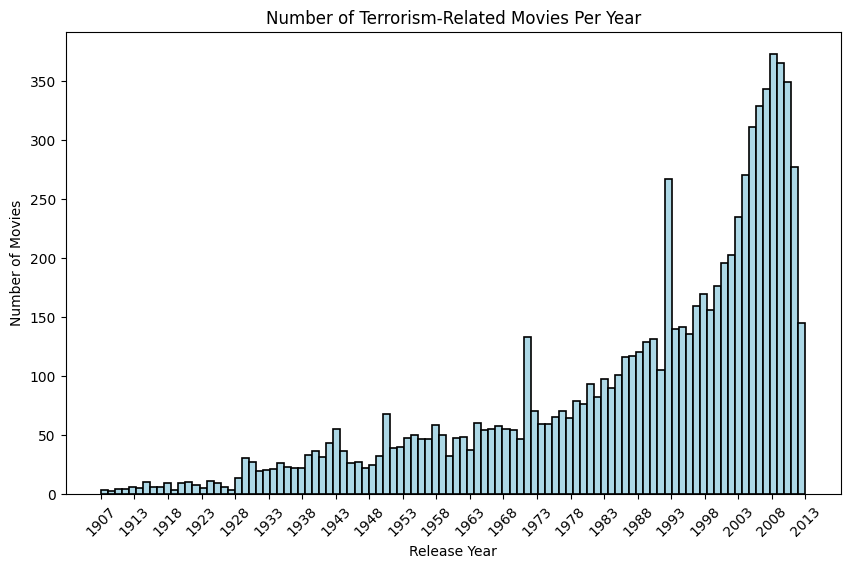

In [ ]:
#We remove the movies that have a NaN value in the release data column.
terrorism_movies.dropna(subset=['Release date'], inplace=True)

fig, ax = plt.subplots(figsize=(10, 6))
plt.hist(terrorism_movies['Release date'],bins= 100, linewidth=1.2, edgecolor='black', color='lightblue')
plt.xlabel('Release Year')
plt.ylabel('Number of Movies')
min_year = int(terrorism_movies['Release date'].min())
max_year = int(terrorism_movies['Release date'].max())
plt.title('Number of Terrorism-Related Movies Per Year')
ax.set_xticks(ax.get_xticks()[::5])
plt.xticks(rotation=45)
plt.show()


### 2.2 Terrorism-related movies per country

We keep the n most represented countries in the visualisation. 

In [ ]:
#Removing the NaN values from the Countries column
df_terrorism_summaries = df_terrorism_summaries[df_terrorism_summaries['Countries'] != '']

exploded = df_terrorism_summaries.explode('Countries')

plot_interactive_pie(exploded, 'Countries', 'Percentage of Movies on terrorism per Country', 4)

In [ ]:
import pycountry
import plotly.graph_objects as go

#to be able to use Plotly's Choropleth map function
def get_iso_code(country_name):
    try:
        return pycountry.countries.lookup(country_name).alpha_3
    except LookupError:
        return None  # If the country name is not found, return None

# Apply the function to get ISO codes
df_terrorism_summaries['iso_alpha'] = df_terrorism_summaries['Countries'].apply(get_iso_code)

# create a Choropleth map:

# Group by 'iso_alpha' to get the count of movies per country code
movie_counts = df_terrorism_summaries.groupby('iso_alpha').size().reset_index(name='Movie Count')

# Create the Choropleth map
fig = go.Figure(data=go.Choropleth(
    locations=movie_counts['iso_alpha'],  # ISO codes for countries
    z=movie_counts['Movie Count'],  # Data to be color-coded
    text=movie_counts['iso_alpha'],  # Country codes
    colorscale='Viridis',
    autocolorscale=False,
    reversescale=False,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_title='Number of Movies',
))

fig.update_layout(
    title_text='Number of Terrorism-related Movies per Country',
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    ),
)
fig.show()

## 3. Emotional depiction

**3.1 Data wrangling for the Sentiment analysis:**

Once we have obtained our movie summaries, based on the list of keywords we defined, we start the data preprocessing for the sentiment analysis, the first step of which is to **tokenize** the sentences present in each movie plot. In other words, we split the summaries in separate sentences using the NTLK (natural language processing) library.
Different approaches are available for tokenization:   
- Splitting text into separate sentences (`nltk.tokenize.sent_tokenize`)  
- Splliting text into seprarate words (`nltk.tokenize.word_tokenize`).  

We chose to use the first approach, as it is more suitable for our analysis. Indeed, keeping the full sentence is important in sentiment analysis since the sentiment often depends strongly on how words are put together rather than individual words. For example, the sentence "I love this movie" has a positive sentiment, while "I do not love this movie" has a negative sentiment, even though both sentences contain the word "love".
     
After splitting the summaries into sentences, we convert all the words to lowercase, so that the words "Love", "LOVE" and "love" are all considered as the same word. 

In [12]:
# Lowercasing and then tokenizing the text; splitting into individual sentences
df_terrorism_summaries['summaries_tokens'] = df_terrorism_summaries['summary'].apply(lambda s: sent_tokenize(s.lower()))
df_terrorism_summaries.head(2)

,W_movie ID,Movie name,Release date,Countries,Languages,Genres,summary,summaries_tokens
0,32986669,Robbery Under Arms,1907-11-02,Australia,Silent film,"Silent film, Drama",Key scenes of the film included the branding o...,[key scenes of the film included the branding ...
1,7870349,Dr. Jekyll and Mr. Hyde,1908-03-07,United States of America,Silent film,"Short Film, Silent film, Horror, Indie, Black-...",Dr. Jekyll and Mr. Hyde began with the raising...,[dr. jekyll and mr. hyde began with the raisin...


Now that the text preprocessing is completed, we can perform the sentiment analysis on the different sentences. Our analysis will be split into 2 parts:  
- **General sentiment analysis:** We are going to use `VaderSentimentAnalyzer`, which is a popular tool usually used to analyze social media content; it is used for informal and short text. We will apply it on every sentence to obtain a sentiment score between -1 (for negative sentences) and 1 (for positive sentences) in the continuous case. For the discrete case, we have 3 possibilities: -1: negative, 0: neutral, 1: positive.     
- **Emotion classification:** VADER is mostly used for general sentiment analysis (positive, neutral, negative) but is limited when it comes to more complex emotions such as fear or terror. We will therefore use more precise approach like **Bert** (Bidirectional Encoder Representations from Transformers) language model. It is a pre-trained model available in the transformers library. More specifically, for computational reasons, we will use a smaller and faster version of the model, named `DistilBERT base uncased` which is indeed smaller than the original Bert model, but still manages to retain most of the original model's performance when it comes to predicting the emotional tone of a text. "Uncased" indicates that the model does not distinguish between capital and lowercase characters. "Base" denotes the size and complexity of the model.

**3.2:  Sentiment analysis:** 

**3.2.1: General sentiment analysis with VADER**

We compute the plot sentiment discrete classes and continuous scores (the two different columns described previously).

In [ ]:
# analyse_text performs sentiment analysis and returns a discrete sentiment class (e.g., positive, negative, neutral).
df_terrorism_summaries["summaries_classification"] = df_terrorism_summaries["summaries_tokens"].apply(lambda s: analyse_text(s))
#Similar to the above, but this 'analyse_text' function is expected to return a continuous score,
# likely a number that represents the sentiment strength (e.g., a score from -1 to 1 where -1 is very negative and 1 is very positive).
df_terrorism_summaries["summaries_scores_per_sentence"] = df_terrorism_summaries["summaries_tokens"].apply(lambda s: analyse_text(s, classify_discrete=False))
# Calculate the number of sentences in each summary.
df_terrorism_summaries["number_of_sentences"] = df_terrorism_summaries["summaries_tokens"].apply(lambda s: len(s))

KeyError: 'summaries_tokens'

In [ ]:
# Display the first 2 elements to view the newly added columns 
df_terrorism_summaries.head(2)

,W_movie ID,Movie name,Release date,Countries,Languages,Genres,summary,iso_alpha,summaries_tokens,summaries_classification,summaries_scores_per_sentence,number_of_sentences
0,32986669,Robbery Under Arms,1907-11-02,Australia,Silent film,"Silent film, Drama",Key scenes of the film included the branding o...,AUS,[Key scenes of the film included the branding ...,"[-1, 0, 0]","[-0.9118, 0.0, 0.0]",3
1,7870349,Dr. Jekyll and Mr. Hyde,1908-03-07,United States of America,Silent film,"Short Film, Silent film, Horror, Indie, Black-...",Dr. Jekyll and Mr. Hyde began with the raising...,USA,[Dr. Jekyll and Mr. Hyde began with the raisin...,"[0, 1, -1, 1, -1, 1]","[0.0, 0.6369, -0.6486, 0.4404, -0.9657, 0.7506]",6


Before moving forward with the analysis using Bert, we classify the emotions using keywords we found using Wikipedia and synonyms dictionary such as Thesaurus.com.

The goal is to organize movies according their dominant emotion. We want to obtain lists of sad movie, happiness movies, etc. We focused on the 6 most basic human emotions (source: online.uwa.edu).

This is just a first glance and the basis for further sentiment analysis that we will be doing in Milestone 3.

In [ ]:
#sadness emotion
sadness_keywords = [
    'sadness', 'sorrow', 'grief', 'depression', 'despair', 'heartache', 'melancholy', 'misery', 'lament', 'ache',
    'woeful', 'desolate', 'gloomy', 'doleful', 'blue', 'mournful', 'downhearted', 'tragic', 'dejected', 'somber',
    'tearful', 'forlorn', 'heavy-hearted', 'grieving', 'dismal', 'dismay', 'hopeless', 'pain', 'wistful', 'regret',
    'agony', 'disheartened', 'weeping', 'distressed', 'miserable', 'sullen', 'lamentation', 'moody', 'wretched',
    'cheerless', 'sombre', 'funereal', 'grim', 'lugubrious', 'hurt', 'bereaved', 'woe', 'anguished',
    'cheerless', 'gloomy', 'lamentation', 'funereal', 'lugubrious', 'agonized', 'mourn', 'aching'
]
movies = df_terrorism_summaries.copy()
sad_movies = movies[movies['summary'].apply(lambda x: has_keyword(x, sadness_keywords))]
print(f"We have {len(sad_movies)} sad movies")

We have 3846 sad movies


In [ ]:
sad_movies.head(2)

,W_movie ID,Movie name,Release date,Countries,Languages,Genres,summary,iso_alpha,summaries_tokens,summaries_classification,summaries_scores_per_sentence,number_of_sentences
4,13254122,What the Daisy Said,1910-07-11,United States of America,"Silent film, English Language","Short Film, Silent film, Drama, Indie, Black-a...",Two farm sisters are feeling romantic and loo...,USA,[Two farm sisters are feeling romantic and lo...,"[1, 1, -1, 1, 0, -1, 1]","[0.4939, 0.34, -0.3182, 0.128, 0.0, -0.8885, 0...",7
6,33031395,A Bushranger's Ransom,1911-03-28,Australia,"Silent film, English Language",Silent film,In 1863 Ben Hall and his men raid the househol...,AUS,[In 1863 Ben Hall and his men raid the househo...,"[-1, -1, 0, 0, 1]","[-0.4767, -0.8271, 0.0, 0.0, 0.4215]",5


In [ ]:
#surprise emotion 
surprise_keywords = [
    'surprise', 'amazement', 'astonishment', 'awe', 'shocked', 'wonder', 'startled', 'stunned', 'astounded', 'shock',
    'dumbfounded', 'jolt', 'unbelievable', 'incredulous', 'stupefied', 'bewildered', 'dazed', 'disbelief', 'astonished',
    'gasp', 'overwhelmed', 'taken aback', 'flabbergasted', 'aghast', 'speechless', 'unforeseen', 'unexpected',
    'astounding', 'incredible', 'mind-blowing', 'eye-opening', 'staggering', 'unexpected', 'surprised', 'unanticipated',
    'sudden', 'wonderment', 'jarring', 'shattering', 'unforeseen', 'stunning', 'stupendous', 'jaw-dropping',
    'awe-inspiring', 'startling', 'impressive', 'extraordinary', 'remarkable', 'unforeseen', 'startling', 'shattering',
    'unpredictable', 'unforeseen', 'awe-struck', 'impressed', 'unplanned', 'amazing', 'suddenness'
]
surprise_movies = movies[movies['summary'].apply(lambda x: has_keyword(x, surprise_keywords))]
print(f"We have {len(surprise_movies)} surprise movies")
surprise_movies.head(2)

We have 3028 surprise movies


,W_movie ID,Movie name,Release date,Countries,Languages,Genres,summary,iso_alpha,summaries_tokens,summaries_classification,summaries_scores_per_sentence,number_of_sentences
1,7870349,Dr. Jekyll and Mr. Hyde,1908-03-07,United States of America,Silent film,"Short Film, Silent film, Horror, Indie, Black-...",Dr. Jekyll and Mr. Hyde began with the raising...,USA,[Dr. Jekyll and Mr. Hyde began with the raisin...,"[0, 1, -1, 1, -1, 1]","[0.0, 0.6369, -0.6486, 0.4404, -0.9657, 0.7506]",6
3,28777800,The Englishman and the Girl,1910-02-17,United States of America,"Silent film, English Language","Short Film, Silent film, Comedy",A small town's drama group is preparing for a ...,USA,[A small town's drama group is preparing for a...,"[1, 1, -1, -1]","[0.34, 0.8225, -0.3743, -0.705]",4


In [ ]:
#happiness movies
happiness_keywords = [
    'joy', 'happiness', 'delight', 'bliss', 'cheer', 'gladness', 'elation', 'euphoria', 'ecstasy', 'jubilation',
    'triumph', 'contentment', 'satisfaction', 'glee', 'serenity', 'exhilaration', 'merriment', 'enjoyment', 'thrill',
    'felicity', 'euphoric', 'lighthearted', 'overjoyed', 'radiant', 'buoyant', 'elated', 'uplifted', 'sunny', 'joyful',
    'gratification', 'jolly', 'blithe', 'ecstatic', 'spirited', 'zestful', 'carefree', 'vibrant', 'mirth', 'gaiety',
    'pleasure', 'rejoicing', 'entertainment', 'amusement', 'exuberant', 'glad', 'thrilled', 'upbeat', 'pleased',
    'ecstatic', 'mirthful', 'radiant', 'jubilant', 'upbeat', 'contented', 'pleasurable', 'exuberant'
]
happiness_movies = movies[movies['summary'].apply(lambda x: has_keyword(x, happiness_keywords))]
print(f"We have {len(happiness_movies)} happiness movies")
happiness_movies.head(2)

We have 2432 happiness movies


,W_movie ID,Movie name,Release date,Countries,Languages,Genres,summary,iso_alpha,summaries_tokens,summaries_classification,summaries_scores_per_sentence,number_of_sentences
1,7870349,Dr. Jekyll and Mr. Hyde,1908-03-07,United States of America,Silent film,"Short Film, Silent film, Horror, Indie, Black-...",Dr. Jekyll and Mr. Hyde began with the raising...,USA,[Dr. Jekyll and Mr. Hyde began with the raisin...,"[0, 1, -1, 1, -1, 1]","[0.0, 0.6369, -0.6486, 0.4404, -0.9657, 0.7506]",6
22,11450070,Mabel at the Wheel,1914-04-18,United States of America,English Language,"Short Film, Silent film, Indie, Black-and-whit...","Charlie, competing with his rival's race car, ...",USA,"[Charlie, competing with his rival's race car,...","[0, 0, -1, 1, -1, 1]","[0.0, 0.0, -0.6808, 0.5267, -0.5267, 0.5318]",6


In [ ]:
#fear emotion
fear_keywords = [
    'terror', 'fear', 'fright', 'panic', 'dread', 'horror', 'anxiety', 'worry', 'apprehension', 'trepidation',
    'nervousness', 'scared', 'awe', 'phobia', 'spine-chilling', 'petrified', 'terrified', 'horrified', 'alarmed',
    'startled', 'creepy', 'shivery', 'timid', 'anxious', 'panicky', 'hysteria', 'creeped out', 'jittery', 'dismay',
    'uneasy', 'frightened', 'spooked', 'eerie', 'haunting', 'apprehensive', 'scary', 'chilling', 'menacing',
    'hysterical', 'foreboding', 'tense', 'panic-stricken', 'shocked', 'unnerved', 'terrifying', 'shuddery', 'afraid',
    'unsettled', 'fainthearted', 'cowardly', 'tremulous', 'distressed', 'anxiousness'
]
fear_movies = movies[movies['summary'].apply(lambda x: has_keyword(x, fear_keywords))]
print(f"We have {len(fear_movies)} fear movies")
fear_movies.head(2)

We have 3611 fear movies


,W_movie ID,Movie name,Release date,Countries,Languages,Genres,summary,summaries_tokens,summaries_classification,summaries_scores_per_sentence,number_of_sentences,Sentiment Score,iso_alpha
4,13254122,What the Daisy Said,1910-07-11,United States of America,"Silent film, English Language","Short Film, Silent film, Drama, Indie, Black-a...",Two farm sisters are feeling romantic and loo...,[Two farm sisters are feeling romantic and lo...,"[1, 1, -1, 1, 0, -1, 1]","[0.4939, 0.34, -0.3182, 0.128, 0.0, -0.8885, 0...",7,0.4939,USA
5,32987279,The Life of Rufus Dawes,1911,Australia,Silent film,Silent film,The film was divided into sections: *ENGLAND -...,[The film was divided into sections: *ENGLAND ...,"[-1, -1, -1, 1, 0, -1, 1, 0, 0, 0]","[-0.8807, -0.4404, -0.34, 0.4215, 0.0, -0.7096...",10,-0.8807,AUS


In [ ]:
#anger emotion
anger_keywords = [
    'rage', 'fury', 'irate', 'outrage', 'indignation', 'angry', 'enraged', 'wrath', 'hostility', 'fuming',
    'infuriated', 'resentment', 'temper', 'agitated', 'seething', 'vexed', 'frustration', 'riled up', 'livid',
    'annoyed', 'bitterness', 'mad', 'displeasure', 'fuming', 'peeved', 'irritated', 'provoked', 'ticked off', 'riled',
    'irritation', 'disgust', 'repulsion', 'loathing', 'revulsion', 'abhorrence', 'odious', 'repugnance', 'sickened',
    'hate', 'disdain', 'contempt', 'aversion', 'abomination', 'appalled', 'detestation', 'grossed out', 'sickening',
    'horrified', 'abominable', 'discontent', 'hostile', 'vindictive', 'exasperation', 'outraged', 'exasperated', 'disgruntled'
]
anger_movies = movies[movies['summary'].apply(lambda x: has_keyword(x, anger_keywords))]
print(f"We have {len(anger_movies)} anger movies")
anger_movies.head(2)

We have 4091 anger movies


,W_movie ID,Movie name,Release date,Countries,Languages,Genres,summary,iso_alpha,summaries_tokens,summaries_classification,summaries_scores_per_sentence,number_of_sentences
17,7884497,Dr. Jekyll and Mr. Hyde,1913-03-06,United States of America,English Language,"Short Film, Science Fiction, Horror, Black-and...","Dr. Henry Jekyll sends a note to his fiancée,...",USA,[Dr. Henry Jekyll sends a note to his fiancée...,"[1, -1, 1, -1, 0, 1, -1, -1, -1, -1, -1, 0, -1]","[0.4215, -0.4588, 0.631, -0.8176, 0.0, 0.2263,...",13
23,13420957,McVeagh of the South Seas,1914-11-02,United States of America,"Silent film, English Language","Silent film, Drama, Indie, Black-and-white",A shipwreck near the Solomon Islands leaves Sa...,USA,[A shipwreck near the Solomon Islands leaves S...,"[0, -1, -1, -1, -1, -1]","[0.0, -0.4404, -0.1901, -0.5574, -0.4939, -0.7...",6


In [ ]:
#disgust movies
disgust_keywords = [
    'disgust', 'repulsion', 'loathing', 'revulsion', 'abhorrence', 'odious', 'repugnance', 'sickened', 'hate',
    'disdain', 'contempt', 'aversion', 'abomination', 'appalled', 'detestation', 'grossed out', 'sickening',
    'horrified', 'abominable', 'discontent', 'hostile', 'vindictive', 'exasperation', 'outraged', 'exasperated',
    'disgruntled', 'nausea', 'revolted', 'yucky', 'offensive', 'displeasure', 'repellent', 'rancid', 'vile',
    'despicable', 'dislike', 'repelling', 'icky', 'turn-off', 'disapproving', 'aberrant', 'foul', 'atrocious',
    'disgusting', 'despise', 'unpleasant', 'repellent', 'revolting', 'loathsome', 'abhorrent', 'off-putting',
    'revolting', 'contemptible', 'abominate', 'disinclined', 'abhor', 'distasteful', 'outrageous', 'fetid',
    'unpalatable', 'frightful', 'sickening', 'vomitous', 'heinous', 'horrifying', 'appalling', 'disgustful'
]
disgust_movies = movies[movies['summary'].apply(lambda x: has_keyword(x, disgust_keywords))]
print(f"We have {len(disgust_movies)} disgust movies")
disgust_movies.head(2)

We have 1630 disgust movies


,W_movie ID,Movie name,Release date,Countries,Languages,Genres,summary,iso_alpha,summaries_tokens,summaries_classification,summaries_scores_per_sentence,number_of_sentences
12,35492984,Call of the Bush,1912-12-12,Australia,"Silent film, English Language","Thriller, Silent film, Drama","The film was billed as ""a story of the Austral...",AUS,"[The film was billed as ""a story of the Austra...","[1, 1, 0]","[0.4404, 0.7506, 0.0]",3
17,7884497,Dr. Jekyll and Mr. Hyde,1913-03-06,United States of America,English Language,"Short Film, Science Fiction, Horror, Black-and...","Dr. Henry Jekyll sends a note to his fiancée,...",USA,[Dr. Henry Jekyll sends a note to his fiancée...,"[1, -1, 1, -1, 0, 1, -1, -1, -1, -1, -1, 0, -1]","[0.4215, -0.4588, 0.631, -0.8176, 0.0, 0.2263,...",13


Below, the goal is to have a first glance at how different sentiments vary in terrorism-related movies. Before, we classified the movies following the sentiment. We obtained a list of sad movies, happines movies, etc. For each sentiment, for example sadness, we chose a random sad movie (random index), and plotted the sentiment scores. This allows to check out the evolution of sentiments throughout the plot of the movie.

NameError: name 'fear_movies' is not defined

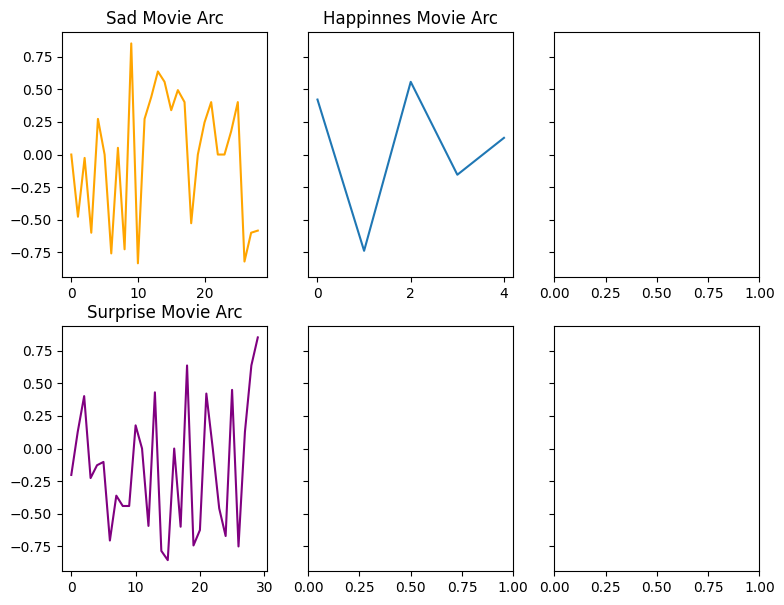

In [ ]:
# now let us visualize different movie arcs for each genre (a sample from each)
fig, axis = plt.subplots(2,3, figsize=(9,7), sharey=True)
# plot the random movie arc
axis[0,0].plot(list(sad_movies.iloc[67]["summaries_scores_per_sentence"]), color="orange")
axis[0,0].set_title("Sad Movie Arc")

axis[0,1].plot(list(happiness_movies.iloc[88]["summaries_scores_per_sentence"]))
axis[0,1].set_title("Happinnes Movie Arc")

axis[1,0].plot(list(surprise_movies.iloc[12]["summaries_scores_per_sentence"]), color="purple")
axis[1,0].set_title("Surprise Movie Arc")

axis[1,1].plot(list(fear_movies.iloc[10]["summaries_scores_per_sentence"]), color="green")
axis[1,1].set_title("Fear Movie Arc")

axis[0,2].plot(list(anger_movies.iloc[67]["summaries_scores_per_sentence"]), color="red")
axis[0,2].set_title("Anger Movie Arc")

axis[1,2].plot(list(disgust_movies.iloc[7]["summaries_scores_per_sentence"]), color="black")
axis[1,2].set_title("Disgust Movie Arc")

fig.text(0.5, 0.04, "Sentence Number (Temporal)", ha="center")
fig.text(0.04, 0.5, "Sentiment Value", va="center", rotation="vertical")

**3.2.2: Specific sentiment analysis with Distilbert-base-uncased**

As mentioned, BERT has several pre-trained models, but we choose to proceed with `Distilbert-base-uncased`. It is suitable for uncased words as well as whole sentences instead of single words, and we already pre-processed our data in this sense. Specifically, we proceed with `distilbert-base-uncased-emotion`, a simplified version of `bert-base-uncased`, with just as much precision, a specialized variant of the DistilBERT language model, fine-tuned specifically for recognizing and classifying emotions in text.   
The results are then saved to a CSV file, `terrorism_summaries_with_distilbert`.

Important imports and variable definitions. The procedure is described below.

In [30]:
'''import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from torch.nn.functional import softmax

model_name = "bhadresh-savani/distilbert-base-uncased-emotion"

# Load pre-trained model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)'''

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

BERT models require further preprocessing, so before applying the model on our dataset, we start by doing some specific text preprocessing:  
- **Tokenizing for BERT:** BERT has its own specific tokenizer, which splits the text into tokens, handles special tokens (like [CLS] (classification), [SEP] (separator)) and manages token length.

- **Padding and Truncation:** BERT requires all input sequences to be of the same length. If a sentence is shorter than the maximum sequence length (512 tokens for BERT), it needs to be padded. Also, longer sequences should be truncated.

- **Converting Tokens to IDs:** The BERT tokenizer converts each token to its corresponding ID in the BERT vocabulary.

`encode_plus()` (from the Hugging Face transformers library) is a method used for preparing input text for processing by transformer models like BERT: 
- Tokenization: It splits the input text into tokens.  

- Adding Special Tokens automatically: For instance, BERT needs [CLS] (used at the start of each sequence for classification tasks) and [SEP] (used as a separator between sentences or at the end of a single sentence).  

- Padding and Truncation: BERT and similar models require inputs of a consistent length. encode_plus can pad shorter inputs (add extra tokens to reach a desired length) and truncate longer inputs. Padding is usually done with a special [PAD] token.  

- Generating Attention Masks: Attention masks are used to let the model know which parts of the input are actual data and which are padding. encode_plus creates these masks, marking each real token with 1 and each padding token with 0.  

- Converting Tokens to IDs: Each token is converted into a corresponding numerical ID based on the model's vocabulary.  

- Returning Tensors: The function outputs the processed data as PyTorch, TensorFlow, or NumPy tensors, depending on the user's setting. This is important because deep learning models work with tensors.  

`torch.no_grad()` is used to deactivate the gradient calculation, which reduces memory consumption and speeds up computations but prevents backpropagation. We use it here because we are not training the model, only using it for inference.

In [31]:
'''def sentiment_analysis(text):
    # Tokenize and truncate the text to 512 tokens
    inputs = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=512,
        truncation=True,
        padding='max_length',
        return_tensors='pt'
    )

    # Move tensors to the same device as the model
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = softmax(outputs.logits, dim=1).cpu().numpy()
        return predictions'''

In [32]:
'''df_terrorism_summaries['emotion_predictions'] = df_terrorism_summaries['summaries_tokens'].apply(
    lambda sentences: [sentiment_analysis(sentence) for sentence in sentences]
)'''

We save the results to a new csv file so we don't have to re-run the code above, since it takes several hours.

In [33]:
'''df_terrorism_summaries.to_csv('terrorism_summaries_with_distilbert.csv', index=False)'''

In [9]:
distilbert_df = pd.read_csv('data/terrorism_summaries_with_distilbert.csv') 
# The results from Bert are the ones corresponding to the column emotion_predictions
distilbert_df.head(5)

,W_movie ID,Movie name,Release date,Countries,Languages,Genres,summary,summaries_tokens,emotion_predictions
0,32986669,Robbery Under Arms,1907-11-02,Australia,Silent film,"Silent film, Drama",Key scenes of the film included the branding o...,"[""key scenes of the film included the branding...","[array([[0.02336912, 0.01652151, 0.00211065, 0..."
1,7870349,Dr. Jekyll and Mr. Hyde,1908-03-07,United States of America,Silent film,"Short Film, Silent film, Horror, Indie, Black-...",Dr. Jekyll and Mr. Hyde began with the raising...,['dr. jekyll and mr. hyde began with the raisi...,"[array([[0.01425847, 0.09961887, 0.00344128, 0..."
2,29391146,The Black Viper,1908-07-25,United States of America,Silent film,Silent film,A thug accosts a girl as she leaves her workpl...,['a thug accosts a girl as she leaves her work...,"[array([[0.00510838, 0.00470041, 0.00098673, 0..."
3,28777800,The Englishman and the Girl,1910-02-17,United States of America,"Silent film, English Language","Short Film, Silent film, Comedy",A small town's drama group is preparing for a ...,"[""a small town's drama group is preparing for ...","[array([[2.4211747e-03, 2.9234146e-03, 3.89401..."
4,13254122,What the Daisy Said,1910-07-11,United States of America,"Silent film, English Language","Short Film, Silent film, Drama, Indie, Black-a...",Two farm sisters are feeling romantic and loo...,['two farm sisters are feeling romantic and l...,"[array([[7.6634547e-04, 1.4728657e-03, 9.94859..."



**a) Data wrangling for the new dataframe containing the predictions froms the Bert model**

In [10]:
#Printing an entry of the new dataframe to better understand the nature of the resulting predictions.
print(distilbert_df.iloc[0]['emotion_predictions'])
print(type(distilbert_df['emotion_predictions']))

[array([[0.02336912, 0.01652151, 0.00211065, 0.6656089 , 0.28894264,
        0.00344719]], dtype=float32), array([[0.00429155, 0.00740028, 0.0010159 , 0.8340297 , 0.15187733,
        0.00138532]], dtype=float32), array([[0.04431726, 0.58980745, 0.01734864, 0.2694819 , 0.06348844,
        0.01555625]], dtype=float32)]
<class 'pandas.core.series.Series'>


Each entry is a list of string representations of numpy arrays, each containing emotion scores. From the information in https://huggingface.co/bhadresh-savani/distilbert-base-uncased-emotion/blob/main/README.md, we know that the predictions are organised as follows, for each sentence in each plot:    
Output:  
[[  
    {'label': 'sadness', 'score':},  
    {'label': 'joy', 'score':},   
    {'label': 'love', 'score':},   
    {'label': 'anger', 'score':},   
    {'label': 'fear', 'score':},   
    {'label': 'surprise', 'score':}  
]]

In order to be able to exploit these scores, we need to convert the arrays of strings into arrays of floats.  We take `distilbert_df['emotion_predictions']`, that contain lists of strings, and perform the following operations:
- Converts each list element to a string.
- Removes specific characters or substrings from each string.
- Converts the modified string back into a list or another appropriate data type.
- Stores the modified values in a new column (`new_col`) of the DataFrame.


In [11]:
# Specifying the elements that we want to remove from the arrays
toRemove = ['\n', '       ' , 'array(' , ' array(' , ', dtype=float32)', ',      dtype=float32)']
new_col= pd.Series()
for i in range(0, len(distilbert_df['emotion_predictions'])):
    elem = distilbert_df['emotion_predictions'][i]
    elem = str(elem)  # Convert list to string
    for word in toRemove:
        elem = elem.replace(word, '')
    e= ast.literal_eval(elem)
    new_col[i] = e

In [12]:
distilbert_df['emotion_predictions'] = pd.Series(new_col, index=distilbert_df.index)
distilbert_df

,W_movie ID,Movie name,Release date,Countries,Languages,Genres,summary,summaries_tokens,emotion_predictions
0,32986669,Robbery Under Arms,1907-11-02,Australia,Silent film,"Silent film, Drama",Key scenes of the film included the branding o...,"[""key scenes of the film included the branding...","[[[0.02336912, 0.01652151, 0.00211065, 0.66560..."
1,7870349,Dr. Jekyll and Mr. Hyde,1908-03-07,United States of America,Silent film,"Short Film, Silent film, Horror, Indie, Black-...",Dr. Jekyll and Mr. Hyde began with the raising...,['dr. jekyll and mr. hyde began with the raisi...,"[[[0.01425847, 0.09961887, 0.00344128, 0.56499..."
2,29391146,The Black Viper,1908-07-25,United States of America,Silent film,Silent film,A thug accosts a girl as she leaves her workpl...,['a thug accosts a girl as she leaves her work...,"[[[0.00510838, 0.00470041, 0.00098673, 0.09395..."
3,28777800,The Englishman and the Girl,1910-02-17,United States of America,"Silent film, English Language","Short Film, Silent film, Comedy",A small town's drama group is preparing for a ...,"[""a small town's drama group is preparing for ...","[[[0.0024211747, 0.0029234146, 0.00038940125, ..."
4,13254122,What the Daisy Said,1910-07-11,United States of America,"Silent film, English Language","Short Film, Silent film, Drama, Indie, Black-a...",Two farm sisters are feeling romantic and loo...,['two farm sisters are feeling romantic and l...,"[[[0.00076634547, 0.0014728657, 0.99485934, 0...."
...,...,...,...,...,...,...,...,...,...
8621,11971266,La Guerre des tuques,NaN,Canada,French Language,"Children's/Family, Animal Picture, Comedy-dram...",The film involves a huge snowball fight betwee...,['the film involves a huge snowball fight betw...,"[[[0.0037364732, 0.0049172374, 0.00078364625, ..."
8622,11515305,Buio Omega,NaN,Italy,"Italian Language, English Language",Horror,"Anna Völkl, the fiance of taxidermist Frank Wy...","['anna völkl, the fiance of taxidermist frank ...","[[[0.6201014, 0.00526572, 0.00172781, 0.011255..."
8623,27613497,Emperor: Young Caesar,NaN,NaN,NaN,Epic,The film will attempt to adapt the first two n...,['the film will attempt to adapt the first two...,"[[[0.0038259383, 0.0018008021, 0.0005960674, 0..."
8624,27646962,Raging Sharks,NaN,"United States of America, Bulgaria",English Language,Horror,"In the opening, a collision between two alien ...","['in the opening, a collision between two alie...","[[[0.00844362, 0.00972516, 0.0012222, 0.103660..."


**Mean emotion scores per country**

1) Computing the mean of each score (sadness, joy, love, anger, fear, surprise) for each movie.

In [13]:
emotion_columns = ['sadness_mean', 'joy_mean', 'love_mean', 'anger_mean', 'fear_mean', 'surprise_mean'] # the 6 emotions scores of Bert
def calculate_mean_scores(emotion_lists):
    """
    CalculateS the mean sentiment scores for each emotion from a list of emotion scores.
    
    Parameters:
    empotion_lists: a list of lists, where each inner list contains sentiment scores 
    for six emotions in a fixed order for each sentence in a movie summary. 
    
    Returns:
    numpy.ndarray: An array of mean sentiment scores for each emotion across all sentences.
    """
    # Flatten the list of lists and calculate mean
    all_scores = [score for sublist in emotion_lists for score in sublist]
    mean_scores = np.mean(all_scores, axis=0) if all_scores else np.zeros(6)
    return mean_scores

# Calculate mean emotion scores
emotion_means = distilbert_df['emotion_predictions'].apply(calculate_mean_scores)

# Add new columns for each emotion
for i, emotion in enumerate(emotion_columns):
    distilbert_df[emotion] = emotion_means.apply(lambda x: x[i])


distilbert_df[['Movie name', 'Countries', 'emotion_predictions'] + emotion_columns].head()

,Movie name,Countries,emotion_predictions,sadness_mean,joy_mean,love_mean,anger_mean,fear_mean,surprise_mean
0,Robbery Under Arms,Australia,"[[[0.02336912, 0.01652151, 0.00211065, 0.66560...",0.023993,0.204576,0.006825,0.589707,0.168103,0.006796
1,Dr. Jekyll and Mr. Hyde,United States of America,"[[[0.01425847, 0.09961887, 0.00344128, 0.56499...",0.007356,0.332904,0.017802,0.372036,0.267010,0.002893
2,The Black Viper,United States of America,"[[[0.00510838, 0.00470041, 0.00098673, 0.09395...",0.009607,0.032934,0.001840,0.396951,0.556052,0.002615
3,The Englishman and the Girl,United States of America,"[[[0.0024211747, 0.0029234146, 0.00038940125, ...",0.006081,0.505637,0.001388,0.238733,0.246608,0.001553
4,What the Daisy Said,United States of America,"[[[0.00076634547, 0.0014728657, 0.99485934, 0....",0.023118,0.202195,0.171025,0.265173,0.192698,0.145792


2) Attributing an ISO code to each country, and removing movies with NAN value countries.

In [14]:
import pycountry
import plotly.graph_objects as go   

#to be able to use Plotly's Choropleth map function
def get_iso_code(country_name):
    try:
        return pycountry.countries.lookup(country_name).alpha_3
    except LookupError:
        return None  # If the country name is not found, return None

# Apply the function to get ISO codes
distilbert_df['iso_alpha'] = distilbert_df['Countries'].apply(get_iso_code)
distilbert_df = distilbert_df.dropna(subset=['iso_alpha'])
distilbert_df.head(2)

,W_movie ID,Movie name,Release date,Countries,Languages,Genres,summary,summaries_tokens,emotion_predictions,sadness_mean,joy_mean,love_mean,anger_mean,fear_mean,surprise_mean,iso_alpha
0,32986669,Robbery Under Arms,1907-11-02,Australia,Silent film,"Silent film, Drama",Key scenes of the film included the branding o...,"[""key scenes of the film included the branding...","[[[0.02336912, 0.01652151, 0.00211065, 0.66560...",0.023993,0.204576,0.006825,0.589707,0.168103,0.006796,AUS
1,7870349,Dr. Jekyll and Mr. Hyde,1908-03-07,United States of America,Silent film,"Short Film, Silent film, Horror, Indie, Black-...",Dr. Jekyll and Mr. Hyde began with the raising...,['dr. jekyll and mr. hyde began with the raisi...,"[[[0.01425847, 0.09961887, 0.00344128, 0.56499...",0.007356,0.332904,0.017802,0.372036,0.267010,0.002893,USA


3) High-level overview: mean of the 6 scores per country

In [15]:
# Overall mean score for each country
distilbert_df['avg_emotion'] = distilbert_df[['sadness_mean', 'joy_mean', 'love_mean', 'anger_mean', 'fear_mean', 'surprise_mean']].mean(axis=1)

# Group by iso code to get the mean of the overall mean score for each country
country_overall_mean = distilbert_df.groupby('iso_alpha')['avg_emotion'].mean().reset_index()

# Plotting
fig = go.Figure(data=go.Choropleth(
    locations=country_overall_mean['iso_alpha'],  
    z=country_overall_mean['avg_emotion'],  
    text=country_overall_mean['iso_alpha'],  
    colorscale='Viridis',
    reversescale=False,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_title="Overall Sentiment Score",
))

fig.update_layout(
    title_text="Overall Average Sentiment Scores by Country",
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    )
)
fig.show()
fig.write_html("data/map_meanscores_bert.html")

For a high-level overview of the distributions of the scores across countries, we generated a map of the mean of all scores per country, without considering the individual emotions separately as a start. From this map, we can draw the following conclusions:
- **Geographical differences:** There seems to be a geographical pattern for the distribution of scores: countries in North America and parts of Europe have slightly higher mean emotional scores than countries of the Middle east of East and parts of Asia (For example China). The depiction of terrorism in movies therefore varies from regions to others, potentially because Western countries might include elements of heroism in these movies, that could increase the scores.  
- **Extreme scores:** Countries with the highest scores are Cameroon (CMR), Senegal (SEN) and Uruguay (URY) whereas those with the lowest scores are Morocco (MAR), Kenya (KEN) and Vietnam (VNM). However, these countries do not usually have a large number of movie productions.
- **Data Range***: This being said, the observations made above should be taken with a grain of salt since the color-scale shows and extremely tight range of emotion scores, around 0.1666 which shows subtle differences between the analysed regions. 

4) Detailed view: A map for each emotion  
Aggregating scores per country and computing mean of each score for each country.

In [16]:
# Grouping by 'Countries' and calculating the mean of sentiment scores for each country
country_agg = distilbert_df.groupby('iso_alpha')[emotion_columns].mean().reset_index()
display(country_agg
        )

,iso_alpha,sadness_mean,joy_mean,love_mean,anger_mean,fear_mean,surprise_mean
0,ARG,0.116502,0.134160,0.007539,0.481007,0.257563,0.003228
1,AUS,0.094809,0.179333,0.019394,0.343159,0.355683,0.007622
2,AUT,0.134196,0.155689,0.003481,0.289775,0.413956,0.002903
3,BEL,0.095969,0.230106,0.012911,0.407038,0.248245,0.005730
4,BGD,0.091736,0.199526,0.063182,0.426312,0.216074,0.003169
...,...,...,...,...,...,...,...
58,URY,0.024719,0.362119,0.005128,0.364881,0.236206,0.006947
59,USA,0.080344,0.188140,0.017125,0.375340,0.329792,0.009259
60,VEN,0.091650,0.107461,0.001851,0.339547,0.445682,0.013809
61,VNM,0.100784,0.030465,0.076308,0.476748,0.313919,0.001776


In [41]:
import plotly.graph_objects as go

# Define the base choropleth map that will be updated by the dropdown
base_choropleth = go.Choropleth(
    locations=country_agg['iso_alpha'],  # ISO alpha-3 codes for each country
    z=country_agg['joy_mean'],  # Initial emotion to display
    text=country_agg['iso_alpha'], # Hover text
    colorscale='Viridis',
    autocolorscale=False,
    reversescale=False,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_title=" Average Sentiment Score",
)

# Create the figure with the base choropleth map
fig = go.Figure(data=base_choropleth)

# Update the layout to add dropdown menu for each one of the 6 emotions
fig.update_layout(
    updatemenus=[
        dict(
            buttons=list([
                dict(
                    args=[{"z": [country_agg['sadness_mean']]}],
                    label="Sadness",
                    method="restyle"
                ),
                dict(
                    args=[{"z": [country_agg['joy_mean']]}],
                    label="Joy",
                    method="restyle"
                ),
                dict(
                    args=[{"z": [country_agg['love_mean']]}],
                    label="Love",
                    method="restyle"
                ),
                dict(
                    args=[{"z": [country_agg['anger_mean']]}],
                    label="Anger",
                    method="restyle"
                ),
                dict(
                    args=[{"z": [country_agg['fear_mean']]}],
                    label="Fear",
                    method="restyle"
                ),
                dict(
                    args=[{"z": [country_agg['surprise_mean']]}],
                    label="Surprise",
                    method="restyle"
                )
            ]),
            direction="down",
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0.1,
            xanchor="left",
            y=1.1,
            yanchor="top"
        ),
    ]
)

fig.update_layout(title_text="Average Sentiment Scores by Country")

# Set the geo dict to the layout
fig.update_geos(
    projection_type= 'equirectangular',)

# Display the figure
fig.show()
fig.write_html("data/map_individual_scores_bert.html")

Analysis of the results
The interactive choropleth maps you have provided display the average sentiment scores for movies related to the theme of terrorism across different countries, based on the emotional analysis of movie summaries. Here's a detailed analysis:

**Global Tendencies:**
- **Joy**: The global trend shows that movies related to terrorism have low joy scores universally. This is consistent with the expectation that terrorism, being a grave and intense subject, is unlikely to be associated with happiness or positive emotions in cinematic portrayals.
  
- **Sadness**: Sadness scores are comparatively higher on a global scale, indicating that the theme of terrorism is often portrayed in a way that evokes sorrow, loss, or tragedy, resonating with the real-world impact of terrorism.

- **Love**: The sentiment of love is not prominent globally in terrorism-related movies, suggesting that while personal relationships may be present, they are not the central focus of these narratives.

- **Anger**: Anger scores show moderate levels in some regions. This could reflect narratives of retaliation, justice, or the intense emotional response to terrorism acts within these films.

- **Fear**: As expected, fear scores are noticeable, reflecting the tension, suspense, and threat that are characteristic of terrorism-related content.

- **Surprise**: Generally, the sentiment of surprise has low scores, which may indicate that plots are more focused on the dramatic unfolding of events rather than on surprising twists or shocks.

**Differences Between Countries:**
- Movies in certain countries, potentially those with a history of significant terrorist activity, might depict higher sadness or anger scores, perhaps reflecting a closer cultural or historical connection to the impact of terrorism.
  
- Regions with lower scores for fear and sadness might indicate a cinematic approach that focuses less on the emotional impact of terrorism and more on analytical or action-oriented aspects.

- Variations in joy or love sentiments across countries could be attributed to different storytelling traditions, censorship, or the presence of subplots that include positive personal stories against a backdrop of terrorism.

**Differences Between Sentiments:**
- The sentiments of sadness and fear are more pronounced than joy, love, or surprise, which aligns with the typical emotional responses to terrorism.
  
- The presence of anger might be tied to narrative elements involving revenge or the pursuit of justice, which can be a common theme in terrorism-related films.

- Love and surprise being less prominent suggests these are not the primary emotions that directors and writers aim to evoke in movies about terrorism.

**Conclusion:**
The sentiment analysis across movies with themes of terrorism reveals a general trend towards negative emotions, with sadness and fear being more prevalent. This reflects the serious nature of terrorism and its depiction in cinema. Differences between countries could be influenced by cultural contexts, historical experiences with terrorism, or regional storytelling styles. The analysis suggests that while there is a global consensus on the emotional undertones of terrorism-related content, there are nuanced differences in how these emotions are experienced or prioritized across different regions.


**Time Series Analysis** : Evolution of emotional depiction over time

1) Line graph evolution

In [42]:
# processing data
distilbert_df['Release date'] = distilbert_df['Release date'].str[:4]
distilbert_df.dropna(subset=['Release date'], inplace=True)
distilbert_df['Release date'] = pd.to_datetime(distilbert_df['Release date'])

emotion_columns = ['sadness_mean', 'joy_mean', 'love_mean', 'anger_mean', 'fear_mean', 'surprise_mean']
melted_df = distilbert_df.melt(id_vars=['Release date'], value_vars=emotion_columns, 
                                        var_name='Emotion', value_name='Mean Score')

AttributeError: Can only use .str accessor with string values!

In [40]:
# Group by 'Release date' and 'Emotion' and calculate the average of the mean score
plotly_df = melted_df.groupby(['Emotion', 'Release date'])['Mean Score'].mean().reset_index()

# Interactive Plot
fig = px.line(plotly_df, x='Release date', y='Mean Score', color='Emotion',
              title='Average Sentiment Scores per Year for Each Emotion',
              labels={'Release date': 'Release Year', 'Mean Score': 'Average Sentiment Score'})

fig.update_xaxes(rangeslider_visible=True)
fig.show()
fig.write_html("data/time_series.html")

AttributeError: Can only use .str accessor with string values!

In [38]:
import plotly.graph_objects as go

# Group by 'Release date' and 'Emotion' and calculate the average of the mean score
heatmap_df = melted_df.groupby(['Emotion', 'Release date'])['Mean Score'].mean().reset_index()

# Pivot the dataframe to create a matrix for the heatmap
heatmap_matrix = heatmap_df.pivot(index='Emotion', columns='Release date', values='Mean Score')

# Create the heatmap
fig = go.Figure(data=go.Heatmap(
    z=heatmap_matrix.values,
    x=heatmap_matrix.columns,
    colorscale= 'Viridis',
    y=heatmap_matrix.index,
    colorbar_title='Average Sentiment Score'
))

# Update the layout
fig.update_layout(
    title='Average Sentiment Scores per Year for Each Emotion',
    xaxis_title='Release Year',
    yaxis_title='Emotion'
)

# Display the heatmap
fig.show()
fig.write_html("data/time_heatmap.html")

In [13]:
distilbert_df['overall_mean'] = distilbert_df[emotion_columns].mean(axis=1)
top_countries_by_movie_count = distilbert_df['Countries'].value_counts().nlargest(10).index


/var/folders/cp/8l695zq55ks4_dq844tm32hm0000gn/T/ipykernel_43617/793167275.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [14]:
import random

# Filter the DataFrame for the countries of interest
filtered_df = distilbert_df[distilbert_df['Countries'].isin(top_countries_by_movie_count)]

# Group by 'Countries' and calculate the mean for each emotion
country_emotion_means = filtered_df.groupby('Countries')[emotion_columns].mean().reset_index()

# Melt the DataFrame for easier plotting
melted_data = country_emotion_means.melt(id_vars='Countries', value_vars=emotion_columns, var_name='Emotion', value_name='Score')

# Specify colors for each emotion (you can choose different colors)
#Choosing a colorblind safe palette and picking 6 random colors
full_scale = px.colors.qualitative.Plotly
random_colors = random.sample(full_scale, 6)
colors = dict(zip(emotion_columns, random_colors))

# Create Plotly figure
fig = go.Figure()

for emotion in emotion_columns:
    subset = melted_data[melted_data['Emotion'] == emotion]
    fig.add_trace(go.Bar(
        x=subset['Countries'],
        y=subset['Score'],
        name=emotion,
        marker_color=colors[emotion]
    ))

# Update layout
fig.update_layout(
    title_text='Average Emotion Scores in Movies in the Top 10 Countries',
    xaxis_title='Country',
    yaxis_title='Average Score',
    barmode='group',
    legend_title="Emotion",
)

# Show the figure
fig.show()

In [15]:
# Filter DataFrame for top 10 countries by average sentiment scores
filtered_df_mean_score = distilbert_df[distilbert_df['Countries'].isin(top_countries_by_movie_count)]

# Melt the DataFrame
melted_df_mean_score = filtered_df_mean_score.melt(id_vars=['Release date', 'Countries'], value_vars=emotion_columns, 
                                                   var_name='Emotion', value_name='Mean Score')

# Group by 'Release date', 'Countries' and 'Emotion'
plotly_df_mean_score = melted_df_mean_score.groupby(['Countries', 'Emotion', 'Release date'])['Mean Score'].mean().reset_index()

# Create the interactive plot for each country
for country in top_countries_by_movie_count:
    country_data = plotly_df_mean_score[plotly_df_mean_score['Countries'] == country]
    fig = px.line(country_data, x='Release date', y='Mean Score', color='Emotion',
                  title=f'Average Sentiment Scores per Year for Each Emotion in {country}',
                  labels={'Release date': 'Release Year', 'Mean Score': 'Average Sentiment Score'})
    fig.update_xaxes(rangeslider_visible=True)
    fig.show()


top_countries_by_movie_count sentiments: subplots

In [16]:
from plotly.subplots import make_subplots
import random
# Create a subplot figure with 5 rows and 2 columns
fig = make_subplots(rows=5, cols=2, subplot_titles=top_countries_by_movie_count)

#Choosing a colorblind safe palette and picking 6 random colors
full_scale = px.colors.qualitative.Plotly
random_colors = random.sample(full_scale, 6)
color_map = dict(zip(emotion_columns, random_colors))

# Iterate over each country and add its plot to the subplot figure
for i, country in enumerate(top_countries_by_movie_count, start=1):
    country_data = plotly_df_mean_score[plotly_df_mean_score['Countries'] == country]
    row = (i - 1) // 2 + 1
    col = (i - 1) % 2 + 1

    for emotion in emotion_columns:
        emotion_data = country_data[country_data['Emotion'] == emotion]
        fig.add_trace(
            go.Scatter(x=emotion_data['Release date'], y=emotion_data['Mean Score'], mode='lines', 
                       name=emotion, showlegend=(i == 1), line=dict(color=color_map[emotion])),  # Show legend only for the first subplot
            row=row, col=col
        )

# Update layout
fig.update_layout(
    height=1500, 
    width=1300, 
    title_text="Average Sentiment Scores per Year for Each Emotion by Country",
    legend=dict(orientation="v", yanchor="top", y=1, xanchor="right", x=1.2),
    showlegend=True,
)
fig.show()


In [17]:
top_genres = ['Drama', 'Action', 'Thriller', 'Comedy', 'Action/Adventure', 'Horror', 'Adventure', 'World cinema', 'Crime Fiction', 'Science Fiction']

# Filter DataFrame for top 10 countries by average sentiment scores
filtered_df_genres = distilbert_df[distilbert_df['Genres'].isin(top_genres)]

# Melt the DataFrame
melted_df_genres = filtered_df_genres.melt(id_vars=['Release date', 'Genres'], value_vars=emotion_columns, 
                                                   var_name='Emotion', value_name='Mean Score')

# Group by 'Release date', 'Countries' and 'Emotion'
plotly_df_genres = melted_df_genres.groupby(['Genres', 'Emotion', 'Release date'])['Mean Score'].mean().reset_index()

# Create a subplot figure with 5 rows and 2 columns
fig = make_subplots(rows=5, cols=2, subplot_titles=top_genres)

#Choosing a colorblind safe palette and picking 6 random colors
full_scale = px.colors.qualitative.Plotly
random_colors = random.sample(full_scale, 6)
color_map = dict(zip(emotion_columns, random_colors))

# Iterate over each country and add its plot to the subplot figure
for i, genre in enumerate(top_genres, start=1):
    genre_data = plotly_df_genres[plotly_df_genres['Genres'] == genre]
    row = (i - 1) // 2 + 1
    col = (i - 1) % 2 + 1

    for emotion in emotion_columns:
        emotion_data = genre_data[genre_data['Emotion'] == emotion]
        fig.add_trace(
            go.Scatter(x=emotion_data['Release date'], y=emotion_data['Mean Score'], mode='lines', 
                       name=emotion, showlegend=(i == 1), line=dict(color=color_map[emotion])),  # Show legend only for the first subplot
            row=row, col=col
        )

# Update layout
fig.update_layout(
    height=1500, 
    width=1300, 
    title_text="Average Sentiment Scores per Year for Each Emotion by Genre",
    legend=dict(orientation="v", yanchor="top", y=1, xanchor="right", x=1.2),
    showlegend=True,
)
fig.show()

Displaying the top 10 highest scores for each emotion

In [18]:
emotion_columns = ['sadness_mean', 'joy_mean', 'love_mean', 'anger_mean', 'fear_mean', 'surprise_mean']
top_movies_by_emotion = {}

for emotion in emotion_columns:
    top_movies_emotion = distilbert_df.nlargest(10, emotion)[['Countries', 'Movie name', 'Release date', 'Genres', emotion]]
    
    # Store the data in the dictionary
    top_movies_by_emotion[emotion] = top_movies_emotion
    display(top_movies_emotion)
    all_top_movies = pd.concat(top_movies_by_emotion.values(), ignore_index=True) # Concatenate all the DataFrames in one dataframe

,Countries,Movie name,Release date,Genres,sadness_mean
6531,United States of America,Already Dead,2007-01-01,"Thriller, Mystery, Psychological thriller, Sus...",0.913069
3718,Philippines,May Minamahal,1993-01-01,"Drama, Filipino Movies",0.789600
4361,United States of America,Every 9 Seconds,1997-01-01,Drama,0.784136
6780,United States of America,Charlie & Me,2008-01-01,"Drama, Family Film, Family Drama, Coming of age",0.756019
2331,United States of America,Little Miss Marker,1980-01-01,"Family Drama, Drama, Comedy, Romantic drama, R...",0.614572
770,United States of America,Submarine command,1951-01-01,"Action/Adventure, Combat Films, Action, Drama,...",0.574046
2841,Japan,Barefoot Gen 2,1986-01-01,"Japanese Movies, Animation, Anime, Drama, War ...",0.563020
5675,United States of America,House of D,2004-01-01,"Drama, Period piece, Coming of age, Indie, Comedy",0.552737
7066,United States of America,Our Disappeared,2008-01-01,Documentary,0.530880
6108,United States of America,Automatons,2006-01-01,"Drama, Science Fiction, Horror",0.519997


,Countries,Movie name,Release date,Genres,joy_mean
4524,United Kingdom,Flying Saucer Rock'n'Roll,1998-01-01,"Short Film, Comedy, Black-and-white",0.993214
6629,United States of America,Illegal Aliens,2007-01-01,"Parody, Science Fiction, Action, Comedy, Telev...",0.912571
7169,Tunisia,De Carthage à Carthage,2009-01-01,"Short Film, Documentary",0.870194
7518,Germany,Plug & Pray,2010-01-01,"Science Fiction, World cinema, Documentary",0.830176
6975,United States of America,The Muslims I Know,2008-01-01,Documentary,0.822858
804,United States of America,Limelight,1952-01-01,"Romantic drama, Musical, Comedy, Black-and-white",0.810242
2375,United States of America,Harry's War,1981-01-01,"Political cinema, Parody, Comedy, Indie",0.792484
442,United States of America,Captain Midnight,1942-01-01,"Adventure, Black-and-white",0.782966
2670,India,Inquilaab,1984-01-01,"Romantic drama, Romance Film, Drama, World cinema",0.762815
5570,United Kingdom,The Reality of the Virtual,2004-01-01,Documentary,0.750646


,Countries,Movie name,Release date,Genres,love_mean
8054,India,Bodyguard,2011-01-01,"Romance Film, Action, Comedy",0.366671
2763,Mexico,Fiebre de Amor,1985-01-01,"Romance Film, Drama, Musical",0.338013
2902,United States of America,Thunder Run,1986-01-01,"Thriller, Action",0.330272
4282,United States of America,Meet Wally Sparks,1997-01-01,"Media Satire, Satire, Comedy",0.326590
5192,South Korea,KT,2002-01-01,NaN,0.322629
6617,United States of America,The Tripper,2007-01-01,"Cult, Stoner film, Horror, Slasher, Horror Comedy",0.316412
2306,Italy,La cicala,1980-01-01,Drama,0.313200
6939,Netherlands,Big Buck Bunny,2008-01-01,"Short Film, Comedy film, Animation",0.312903
6471,India,Koodal Nagar,2007-01-01,Romance Film,0.289292
33,United States of America,Fatty's Plucky Pup,1915-01-01,"Short Film, Silent film, Indie, Black-and-whit...",0.276272


,Countries,Movie name,Release date,Genres,anger_mean
3377,Hong Kong,Fatal Termination,1990-01-01,"Thriller, Action",0.996464
8287,United States of America,The Smurfs 2,2013-01-01,"Family Film, Fantasy, Comedy, Animation",0.981858
1501,United States of America,The St. Valentine's Day Massacre,1967-01-01,"Crime Fiction, Gangster Film, Drama, Crime Drama",0.974822
5892,India,Insan,2005-01-01,"Action/Adventure, Drama, World cinema, War film",0.973586
7462,Turkey,Nefes: Vatan Sağolsun,2009-01-01,Drama,0.973158
3224,Japan,Violent Cop,1989-01-01,"Thriller, Japanese Movies, Crime Fiction, Acti...",0.973111
3327,United States of America,Skinner,1990-01-01,"Psychological thriller, Horror, Slasher, Indie",0.971934
7220,India,Hook Ya Crook,2009-01-01,"Comedy, World cinema",0.951088
859,United States of America,Man with the Steel Whip,1954-01-01,"Western, Action, Adventure, Black-and-white",0.949653
930,South Korea,Box of Death,1955-01-01,"Action, Drama",0.934101


,Countries,Movie name,Release date,Genres,fear_mean
134,United States of America,Seven Footprints to Satan,1929-01-01,"Crime Fiction, Mystery, Drama",0.992546
7377,United States of America,Held Hostage,2009-01-01,"Crime Fiction, Crime Thriller, Courtroom Drama...",0.990698
6066,Mexico,La mujer de mi hermano,2005-01-01,"LGBT, World cinema, Family Drama, Drama, Roman...",0.988742
4640,United States of America,Lycanthrope,1999-01-01,Horror,0.988424
2658,South Korea,The Stranger,1984-01-01,"Romance Film, Drama",0.986492
3201,Hong Kong,Fatal Vacation,1989-01-01,"Action/Adventure, Action, Chinese Movies, Worl...",0.984663
1646,United States of America,The Extraordinary Seaman,1969-01-01,"Comedy, War film",0.981124
7927,United Kingdom,A Lonely Place to Die,2011-01-01,"Crime Fiction, Thriller, Adventure",0.976492
1987,United States of America,Deafula,1975-01-01,Horror,0.971924
7391,United States of America,Blood in the Water,2009-01-01,Horror,0.965940


,Countries,Movie name,Release date,Genres,surprise_mean
1661,India,Tum Haseen Main Jawaan,1970-01-01,World cinema,0.254714
5370,United Kingdom,Palestine Is Still the Issue,2003-01-01,Documentary,0.241351
5875,India,Maayavi,2005-01-01,"Drama, Comedy",0.233886
4211,France,Jaguar,1996-01-01,"Drama, Adventure Comedy, Adventure, World cine...",0.228365
7134,United Kingdom,The Children,2008-01-01,Horror,0.202777
6928,India,Satya In Love,2008-01-01,"Action, Drama",0.198914
4369,United States of America,House of Frankenstein 1997,1997-01-01,"Mystery, Action, Horror",0.187981
994,United States of America,Hot Shots,1956-01-01,Comedy,0.175170
1633,United States of America,The Thousand Plane Raid,1969-01-01,"Action, Drama, Adventure, Docudrama, War film",0.166380
2929,United States of America,Static,1986-01-01,"Drama, Comedy-drama, Indie, Comedy",0.158366


In [19]:
distilbert_df.head(2)

,W_movie ID,Movie name,Release date,Countries,Languages,Genres,summary,summaries_tokens,emotion_predictions,sadness_mean,joy_mean,love_mean,anger_mean,fear_mean,surprise_mean,iso_alpha,avg_emotion,overall_mean
0,32986669,Robbery Under Arms,1907-01-01,Australia,Silent film,"Silent film, Drama",Key scenes of the film included the branding o...,"[""key scenes of the film included the branding...","[[[0.02336912, 0.01652151, 0.00211065, 0.66560...",0.023993,0.204576,0.006825,0.589707,0.168103,0.006796,AUS,0.166667,0.166667
1,7870349,Dr. Jekyll and Mr. Hyde,1908-01-01,United States of America,Silent film,"Short Film, Silent film, Horror, Indie, Black-...",Dr. Jekyll and Mr. Hyde began with the raising...,['dr. jekyll and mr. hyde began with the raisi...,"[[[0.01425847, 0.09961887, 0.00344128, 0.56499...",0.007356,0.332904,0.017802,0.372036,0.267010,0.002893,USA,0.166667,0.166667


In [20]:
def calculate_mean_scores_per_movie(emotion_lists):
    """
    Calculates the mean sentiment scores for each emotion from a list of emotion scores for each sentence in a movie summary.
    
    Parameters:
    emotion_lists: a list of lists, where each inner list contains sentiment scores 
    for six emotions in a fixed order for each sentence in a movie summary. 
    
    Returns:
    list: A list of mean sentiment scores for each emotion across all sentences for one movie.
    """
    # Check if emotion_lists is not empty
    if emotion_lists:
        # Stack the list of lists to create a 2D numpy array
        scores_array = np.vstack(emotion_lists)
        # Calculate the mean across sentences (axis=0) for each emotion
        mean_scores = np.mean(scores_array, axis=0)
    else:
        # If emotion_lists is empty, return a list of zeros
        mean_scores = [0] * 6
        
    return mean_scores.tolist()

# Apply the function to each row's 'emotion_predictions' column
distilbert_df['mean_emotion_scores'] = distilbert_df['emotion_predictions'].apply(calculate_mean_scores_per_movie)

# Now the 'mean_emotion_scores' column contains a list of the mean scores for each emotion
# Let's see the DataFrame structure with the new column
display(distilbert_df[['Movie name', 'Countries', 'mean_emotion_scores']])


/var/folders/cp/8l695zq55ks4_dq844tm32hm0000gn/T/ipykernel_43617/270044560.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Movie name,Countries,mean_emotion_scores
0,Robbery Under Arms,Australia,"[0.02399264333333333, 0.20457641333333335, 0.0..."
1,Dr. Jekyll and Mr. Hyde,United States of America,"[0.007355513096666668, 0.3329040648666666, 0.0..."
2,The Black Viper,United States of America,"[0.00960685118, 0.032933848, 0.001840091435999..."
3,The Englishman and the Girl,United States of America,"[0.006081293450000001, 0.50563742865, 0.001387..."
4,What the Daisy Said,United States of America,"[0.02311769275285714, 0.20219465224285713, 0.1..."
...,...,...,...
8282,Chakravyuh,India,"[0.05346492625064517, 0.24919098265806452, 0.0..."
8283,Cold War,China,"[0.07040285507399999, 0.2702706540866667, 0.00..."
8285,Zero Dark Thirty,United States of America,"[0.009703195, 0.457617035, 0.004432995, 0.1234..."
8286,Pain & Gain,United States of America,"[0.03202560333333333, 0.4116699, 0.01187698, 0..."


In [21]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

selected_movies = distilbert_df[distilbert_df['Movie name'].isin(all_top_movies['Movie name'])]
countries = selected_movies['Countries'].unique()
country_sentiments = {}

# Setup the figure layout with appropriate size
fig = make_subplots(rows=len(countries), cols=1, subplot_titles=countries)
fig.update_layout(height=300*len(countries), title_text="Sentiment Evolution per Sentence in Movies by Country")

# Loop through each country and plot sentiment scores per sentence
for i, country in enumerate(countries, start=1):
    # Filter the movies for the current country
    country_movies = selected_movies[selected_movies['Countries'] == country]
    country_scores = country_movies['mean_emotion_scores']
    mean_scores = [sum(scores) / len(scores) for scores in zip(*country_scores)]
    
    fig.add_trace(go.Scatter(x=np.arange(len(mean_scores)), y=mean_scores, showlegend=False), row=i, col=1)
    fig.update_yaxes(title_text='Score', row=i, col=1)
    fig.update_xaxes(title_text='Number of Sentences', row=i, col=1)

fig.show()



## 4. Are there specific genres associated to terrorism movies?

Each movie is associated with various genres. The genre of a movie is a way to categorize it. It reflects the movie’s narrative elements, thematic content, stylistic approach, and the emotional response it aims to evoke in the audience. It allows audiences and film-makers to understand the type of content they can expect from a movie. 

Below, we describe each method that we will be using to analyze the association between genres and terrorism movies.
For each method, we describe what the method does, why it is interesting in the context of genres and terrorism movies and how it works.
We also do the necessary data pre-processing for each method, as well as the first visualizations.

The analysis is in three parts: Frequency analysis, heatmap of counts of movies of certain genres of different countries, and a chi-squared independence test.

### 4.1 Frequency Analysis
__What It Does__: Frequency analysis counts how often each genre appears in movies about terrorism vs in non-terrorism movies.

__Why It’s Interesting__: This method would provide a clear, quantitative measure of the association between genres and terrorism-themed movies. It could reveal if terrorism movies are associated with certain genres, like action or drama.

__How It Works__: We first filter our dataset for movies that are classified as related to terrorism. We do this by keyword search within movie descriptions. We define a list of keywords that are associated with terrorism, then only keep the movies whose plot contains at least one of these keywords. Then, we count the frequency of each genre within this subset and compare it to the overall frequency of genres in the entire dataset.

__Data Pre-Processing and Visualization__: We need to write a code that allows to count the genres. We also do a visualization of the top 10 most common genres in non-terrorism movies vs in terrorism-related movies.

We want to compare the frequency of genres between terrorism-related movies and non-terrorism-related movies.

In [28]:
#Non-terrorism movies in their original format
non_terrorism_movies = m_data_copy[~m_data_copy['W_movie ID'].isin(movie_ids)]
#Terrorism movies in their original format
t_movies = m_data_copy[m_data_copy['W_movie ID'].isin(movie_ids)][['W_movie ID','Movie name', 'Release date','Countries', 'Languages', 'Genres','Box office revenue']]
t_movies = t_movies.sort_values(by=['Release date'])
print(f"Number of terrorism-related movies: {len(t_movies)}")
print(f"Number of non terrorism-related movies: {len(non_terrorism_movies)}")

Number of terrorism-related movies: 8626
Number of non terrorism-related movies: 73114


In the data set without terrorism-related movies `non_terrorism_movies`, we have 73114 movies.
In the filtered data set `t_movies`, we have 8626 movies, which correspond to terrorism-related movies.

In [ ]:
display(non_terrorism_movies.head(2))

,W_movie ID,F_movie ID,Movie name,Release date,Box office revenue,Runtime,Languages,Countries,Genres
0,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
1,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."


In [ ]:
display(t_movies.head(2))

,W_movie ID,Movie name,Release date,Countries,Languages,Genres,Box office revenue
42214,32986669,Robbery Under Arms,1907-11-02,"{""/m/0chghy"": ""Australia""}","{""/m/06ppq"": ""Silent film""}","{""/m/06ppq"": ""Silent film"", ""/m/07s9rl0"": ""Dra...",NaN
64189,7870349,Dr. Jekyll and Mr. Hyde,1908-03-07,"{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",NaN


Now, we start the genre analysis. We want to take a look at the top 10 most common genres in both terrorism-related movies `t_movies` and non-terrorism-related movies.

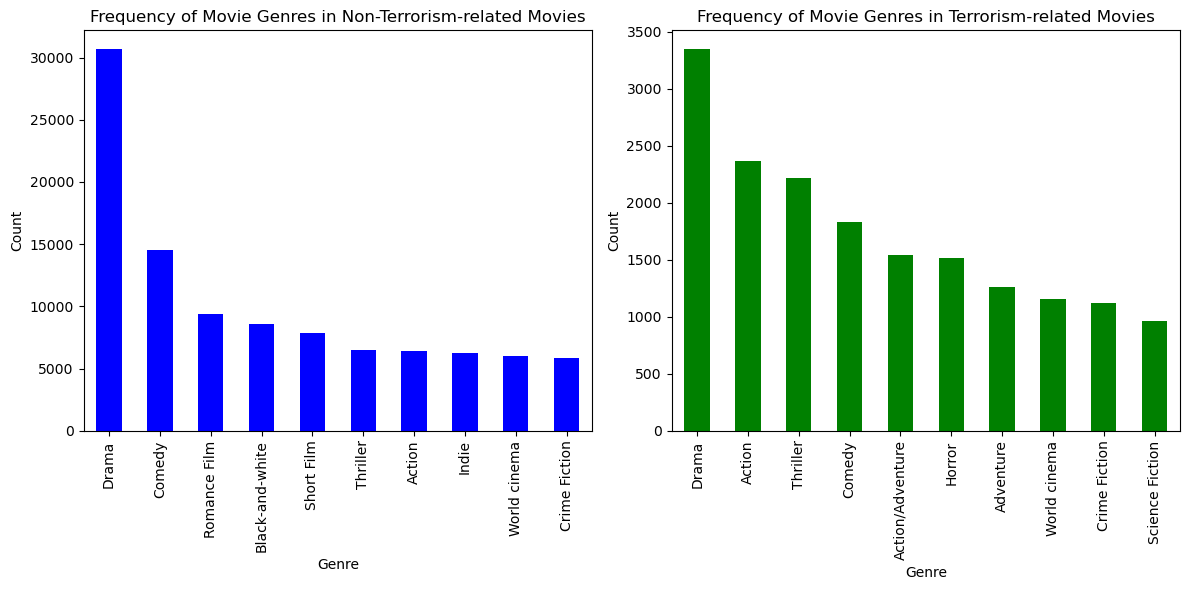

In [ ]:
#Define a function to parse the genre column
def parse_genre(genre_str):
    try:
        # Convert the string representation of a dictionary into an actual dictionary
        genre_dict = ast.literal_eval(genre_str)
        # Return the values (genres) of the dictionary
        return list(genre_dict.values())
    except ValueError:
        # In case of any parsing error, return an empty list
        return []

## Non-terrorism movies

#Apply the function to each row in the genre column and flatten the list of lists
genres_series = non_terrorism_movies['Genres'].apply(parse_genre)
all_genres = [genre for sublist in genres_series for genre in sublist]

#Create a frequency count of each genre
genre_counts = pd.Series(all_genres).value_counts()

#Only keep the top 10 most common genres
top_10_non_terrorism_movies = genre_counts.nlargest(10)

## Terrorism-related movies

#Apply the function to each row in the genre column and flatten the list of lists
genres_series = t_movies['Genres'].apply(parse_genre)
all_genres = [genre for sublist in genres_series for genre in sublist]

#Create a frequency count of each genre
genre_counts = pd.Series(all_genres).value_counts()

#Only keep the genres that are present in more than 1000 movies
top_10_terrorism_movies = genre_counts.nlargest(10)

#Plot the barplots of movie genres for terrorism vs non-terrorism-related movies
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

top_10_non_terrorism_movies.plot(kind='bar', ax=axes[0], color='blue')
axes[0].set_title('Frequency of Movie Genres in Non-Terrorism-related Movies')
axes[0].set_xlabel('Genre')
axes[0].set_ylabel('Count')

top_10_terrorism_movies.plot(kind='bar', ax=axes[1], color='green')
axes[1].set_title('Frequency of Movie Genres in Terrorism-related Movies')
axes[1].set_ylabel('Count')
axes[1].set_xlabel('Genre')

plt.tight_layout()
plt.show()

### 4.2 Heatmap of genres of terrorism movies between different countries

__What It Does__: The heatmap will show the counts of movies of each genre for each country.

__Why It’s Interesting__: This method would provide a qualitative measure of the association between genres of terrorism-themed and countries. It could reveal if terrorism movies in the USA of the United Kingdom are associated with certain genres, like action or drama, etc.

__How It Works__: We look for the 10 countries that have the most terrorism-related movies. We create a matrix where each cell contains the count of movies for a particular genre in a particular country. Since we are only intered in these 10 countries, we filter the matrix to inclue just those. Then we plot the heatmap from the matrix.

__Data Pre-Processing and Visualization__: To prepare our data, we need to ensure that the dataset is structured so that each movie has a genre list and an associated country.

First, let's start by identifying the 10 countries that have the most terrorism-related movies.

Text(0, 0.5, 'Movies')

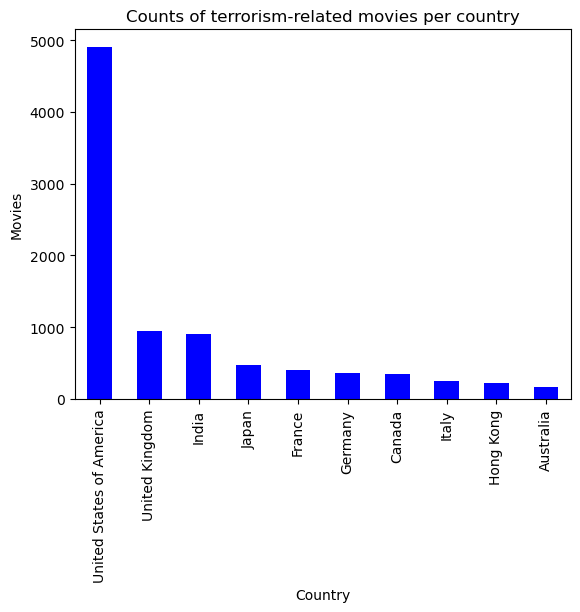

In [ ]:
#Define a function to parse the 'Countries' column
def parse_countries(countries_str):
    try:
        # Convert the string representation of a dictionary into an actual dictionary
        countries_dict = ast.literal_eval(countries_str)
        # Return the values (country names) of the dictionary
        return list(countries_dict.values())
    except ValueError as e:
        # In case of any parsing error, return an empty list
        return []

#Apply the function to each row in the 'Countries' column
# This will create a Series of lists
countries_series = t_movies['Countries'].apply(parse_countries)

#Explode the lists into separate rows
exploded_countries = countries_series.explode()

#Count the occurrences of each country
country_counts = exploded_countries.value_counts()

#Only keep the 10 countries that have the most movies
country_counts = country_counts.nlargest(10)

plt.figure()
country_counts.plot(kind='bar', color='blue')
plt.title('Counts of terrorism-related movies per country')
plt.xlabel('Country')
plt.ylabel('Movies')

These 10 countries are: United States of America, United Kingdom, India, Japan, France, Germany, Canada, Italy, Hong Kong, Australia.

We process the Languages, Countries and Genres columns in the terrorism_movies DataFrame that contain JSON-like strings. We convert the strings in these columns into Python lists containing the values from the JSON object

In [ ]:
json_cols = ["Languages", "Countries", "Genres"]
list_terrorism_movies = t_movies.copy()
for col in json_cols:
    list_terrorism_movies[col] = list_terrorism_movies[col].apply(lambda x: list(json.loads(x).values()))

Now, we only keep the movies that are from at least one of the 10 countries mentioned before, and that have at least one genre from the 10 genres mentioned before.

In [ ]:
temp = list_terrorism_movies[list_terrorism_movies['Countries'].apply(contains_countries_of_interest)]
movies_of_interest = temp[temp['Genres'].apply(contains_genres_of_interest)]
movies_of_interest.head(2)

,W_movie ID,Movie name,Release date,Countries,Languages,Genres,Box office revenue
42214,32986669,Robbery Under Arms,1907-11-02,[Australia],[Silent film],"[Silent film, Drama]",NaN
64189,7870349,Dr. Jekyll and Mr. Hyde,1908-03-07,[United States of America],[Silent film],"[Short Film, Silent film, Horror, Indie, Black...",NaN


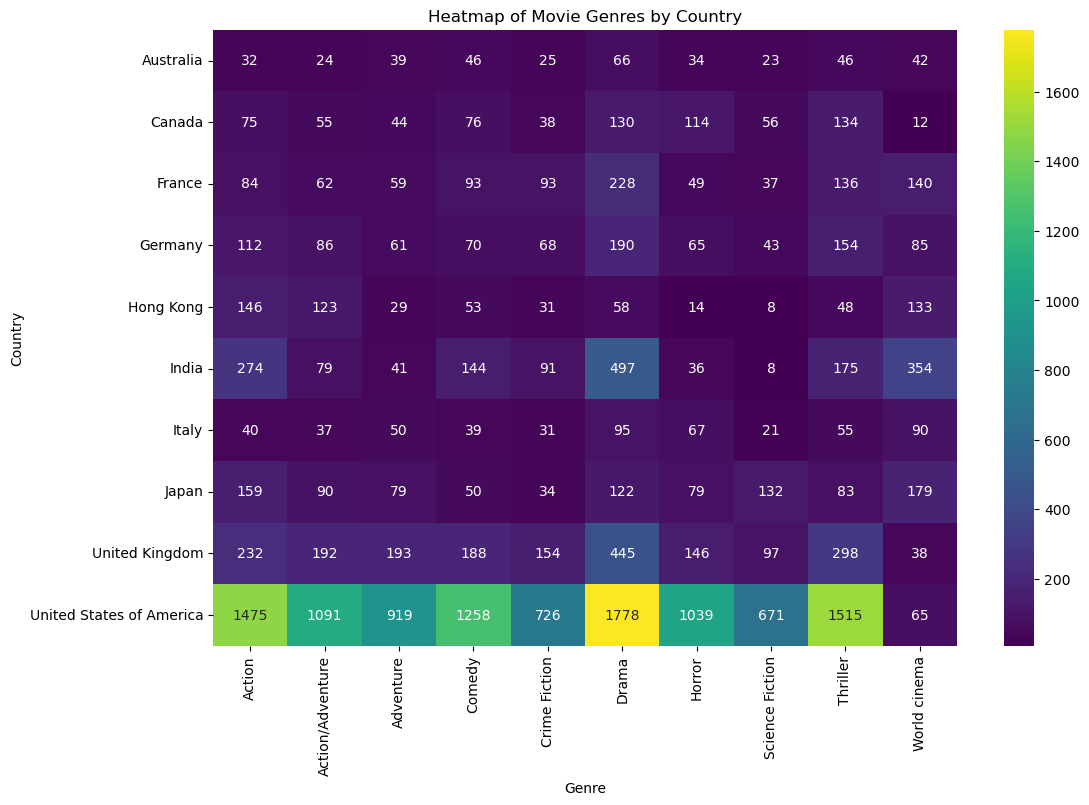

In [ ]:
#Explode the data frame twice w.r.t. Countries and Genres
exploded_data = movies_of_interest.explode('Countries').explode('Genres')

#Define the countries of interest
countries_of_interest = [
        "United States of America", "United Kingdom", "India", "Japan",
        "France", "Germany", "Canada", "Italy", "Hong Kong", "Australia"]

#Define the genres of interest
genres_of_interest = ['Drama', 'Action', 'Thriller', 'Comedy', 'Action/Adventure', 'Horror',
                          'Adventure', 'World cinema', 'Crime Fiction', 'Science Fiction']

#Only keep elements of the exploded data that have one of the countries of interest and one of the genres of itnerest
temp = exploded_data[
    exploded_data['Countries'].isin(countries_of_interest) & 
    exploded_data['Genres'].isin(genres_of_interest)]

# Create a pivot table with countries as rows, genres as columns, and counts as values
heatmap_set = pd.pivot_table(temp, index='Countries', columns='Genres', aggfunc='size', fill_value=0)

#Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_set, annot=True, fmt='d', cmap='viridis')
plt.title('Heatmap of Movie Genres by Country')
plt.xlabel('Genre')
plt.ylabel('Country')
plt.show()

As we can see, since there are a lot more movies from the USA, we can't really see the variation between genres for the rest of the countries. 
Therefore, we decided to check out the genre frequency of the USA movies alone, and repeat the visualization for the rest of the countries.

First, let's remove the USA from list of countries of interest.

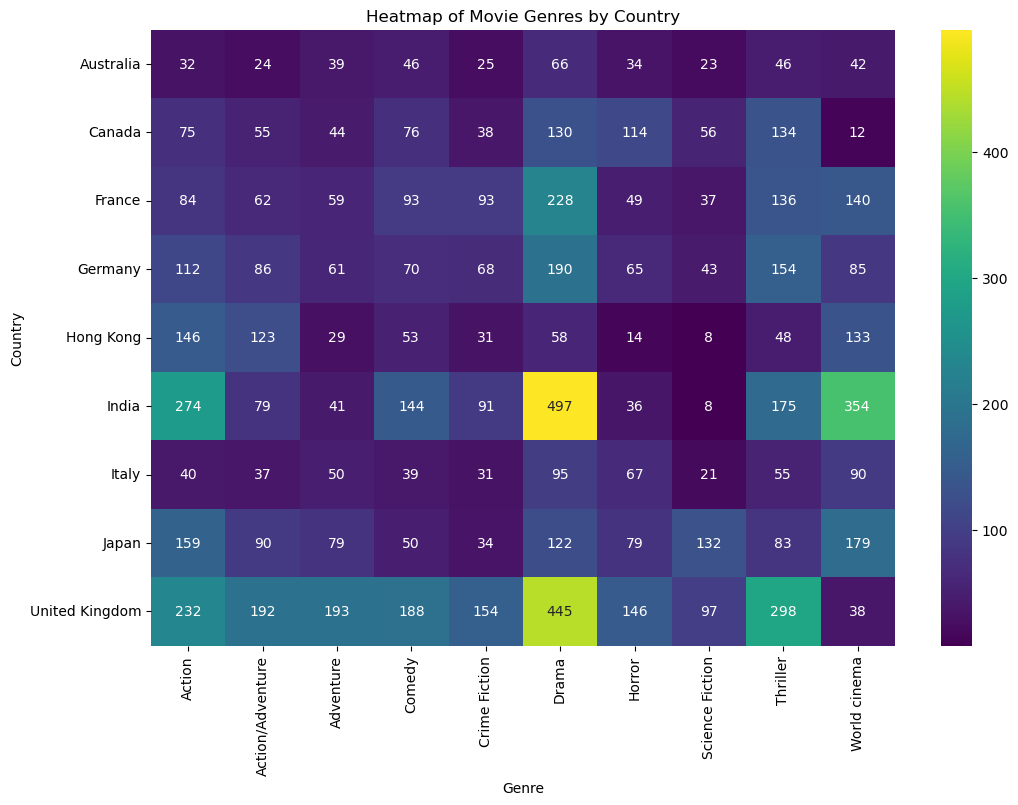

In [ ]:
countries_of_interest = [
        "United Kingdom", "India", "Japan",
        "France", "Germany", "Canada", "Italy", "Hong Kong", "Australia"]

temp = exploded_data[
    exploded_data['Countries'].isin(countries_of_interest) & 
    exploded_data['Genres'].isin(genres_of_interest)]

# Create a pivot table with countries as rows, genres as columns, and counts as values
heatmap_set = pd.pivot_table(temp, index='Countries', columns='Genres', aggfunc='size', fill_value=0)

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_set, annot=True, fmt='d', cmap='viridis')
plt.title('Heatmap of Movie Genres by Country')
plt.xlabel('Genre')
plt.ylabel('Country')
plt.show()

Now, let's do the visualization for the USA alone.

Text(0, 0.5, 'Movies')

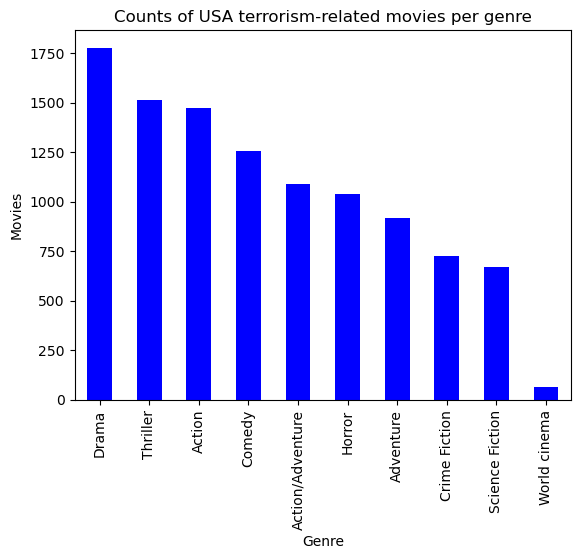

In [ ]:
temp = exploded_data[exploded_data['Countries'] == 'United States of America']
temp = temp[temp['Genres'].isin(genres_of_interest)]

#Count the occurrences of each country
genre_counts = temp['Genres'].value_counts()

plt.figure()
genre_counts.plot(kind='bar', color='blue')
plt.title('Counts of USA terrorism-related movies per genre')
plt.xlabel('Genre')
plt.ylabel('Movies')

As we can notice, except for Hong Kong and Japan, the most prevalent genre is Drama. In the part about sentimental analysis, it could be interesting to only focus on the Drama movies and see whether the way each country depicts its Drama terrorism-related movies is different, sentimental-wise.

### 4.3 Chi-Square Test of Independence
__What It Does__: Tests whether there is a significant association between movie genres and their portrayal of terrorism.

__Why It’s Interesting__: This statistical test can validate whether any observed association between genres and terrorism portrayal is statistically significant, rather than due to random chance.

__How It Works__: The Chi-Square test will tell you whether the distribution of genres in terrorism-related movies is different from what would be expected if there was no association between genre and terrorism content.

__Data Pre-Processing Needed__: You will need a table where one column is genres and the other is a binary variable indicating whether the movie is terrorism-related.

First, we create a new column for the feature Terrorism-related. This feature is binary. Its value is 1 if the movie is terrorism-related, and it is 0 if it is not.

In [ ]:
m_data_chi = m_data_copy.copy()
m_data_chi['Terrorism-related'] = m_data_copy['W_movie ID'].apply(lambda x: 1 if x in movie_ids else 0)

m_data_chi['Release year'] = m_data_chi['Release date'].str[:4]
m_data_chi.drop(columns=['F_movie ID','Box office revenue', 'Runtime', 'Release date'], axis=1, inplace=True)

Now, we process the Genres columns in the m_data_chi DataFrame that contain JSON-like strings. We convert the strings in these columns into Python lists containing the values from the JSON object.

In [ ]:
json_cols = ["Genres"]
for col in json_cols:
    m_data_chi[col] = m_data_chi[col].apply(lambda x: list(json.loads(x).values()))

Finally, we create the chi-square test data that is a table where one column is the Genre and the other is the Terrorism-related binary variable.

In [ ]:
exploded_data = m_data_chi.explode('Genres')
chi_square_data = exploded_data[['Genres', 'Terrorism-related']]
chi_square_data.head()

,Genres,Terrorism-related
0,Mystery,0
0,Biographical film,0
0,Drama,0
0,Crime Drama,0
1,Crime Fiction,0


## 5. How popular are terrorism-related movies in comparison to others?

### 5.1 Statistics of Box Office Collections & Visualizations

In [ ]:
#Keeping all the movies with box office
revenue_data = m_data.dropna(subset=['Box office revenue'])
#Keeping terrorism movies with box office
other_movies= revenue_data[~revenue_data['W_movie ID'].isin(movie_ids)][['W_movie ID','Movie name', 'Release date','Countries', 'Languages', 'Genres','Box office revenue']]

other_movies = other_movies.sort_values(by=['Release date'])
other_movies['Release date']=  other_movies['Release date'].str[:4]
other_movies.dropna(subset=['Release date'], inplace=True)

<function matplotlib.pyplot.show(close=None, block=None)>

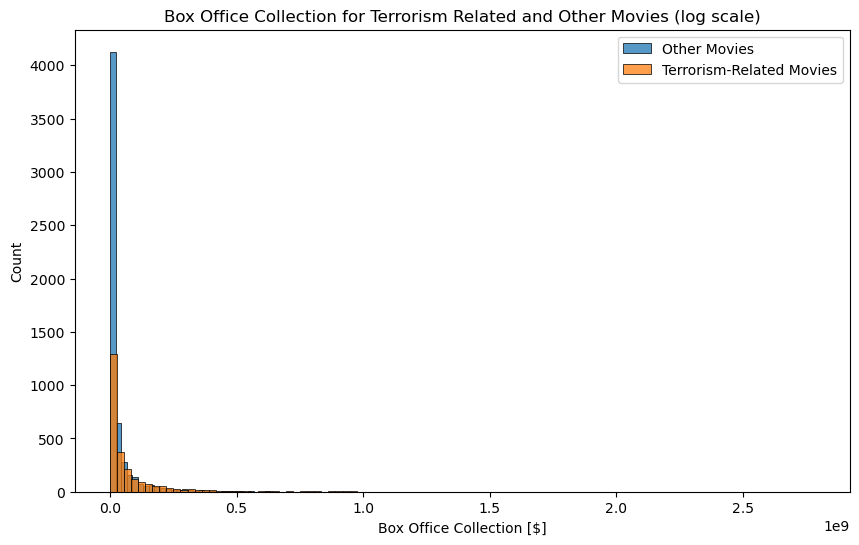

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(other_movies['Box office revenue'], bins=100, log_scale=False, label='Other Movies')
sns.histplot(terrorism_movies['Box office revenue'], bins=100, log_scale=False, label= 'Terrorism-Related Movies')
plt.title('Box Office Collection for Terrorism Related and Other Movies (log scale)')
plt.xlabel('Box Office Collection [$]')
plt.legend()
plt.show

We observed that the box office revenue distribution exhibits a **heavy tail**. Consequently, rather than focusing on the mean, 23 consider the log-transformed values of the box office collection.  
**LOG IS YOUR FRIEND !**

<function matplotlib.pyplot.show(close=None, block=None)>

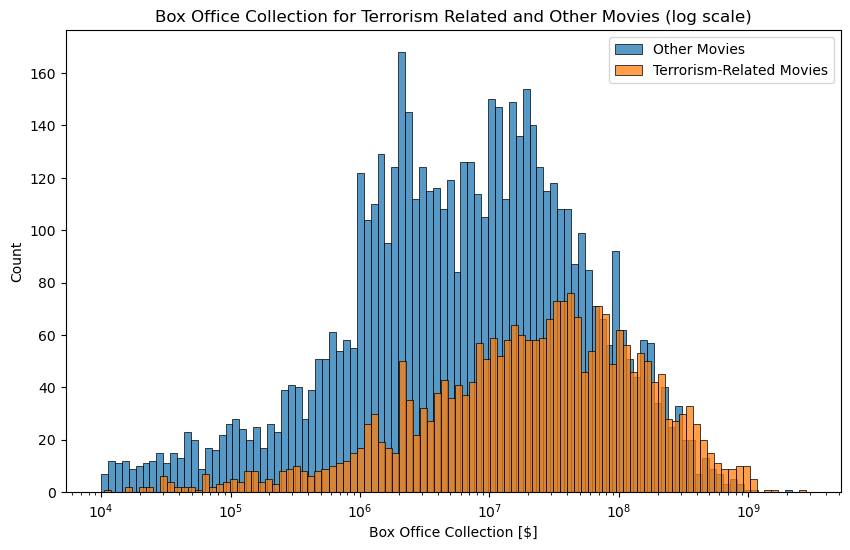

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(other_movies['Box office revenue'], bins=100, log_scale=True, label='Other Movies')
sns.histplot(terrorism_movies['Box office revenue'], bins=100, log_scale=True, label= 'Terrorism-Related Movies')
plt.title('Box Office Collection for Terrorism Related and Other Movies (log scale)')
plt.xlabel('Box Office Collection [$]')
plt.legend()
plt.show


As mentionned before the box office revenue exhibits heavy tail so the mean is meaningless. Hence we first do a log-transformation and then compute the mean of the box office revenue.

In [ ]:
terro_log_revenue= np.log1p(terrorism_movies['Box office revenue'])
others_log_revenue= np.log1p(other_movies['Box office revenue'])

terror_log_revenue_mean= terro_log_revenue.mean()
others_log_revenue_mean= others_log_revenue.mean()

print(terror_log_revenue_mean)
print(others_log_revenue_mean)

16.82493875164396
15.624203760130868


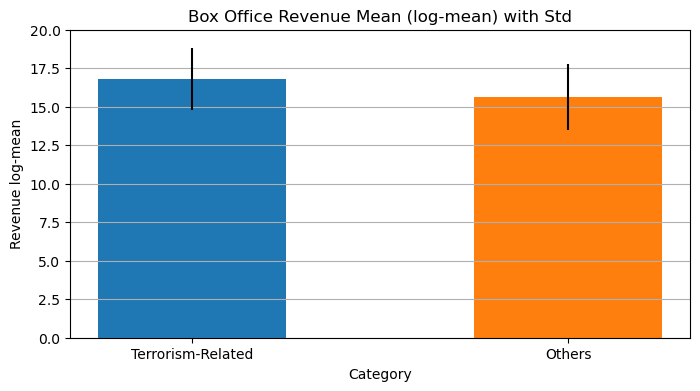

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))
categories= ['Terrorism-Related','Others']
log_means= [terror_log_revenue_mean,others_log_revenue_mean]
uncertainties = [np.std(terro_log_revenue, ddof=1), np.std(others_log_revenue, ddof=1)]


for i in range(2):
    plt.bar(categories[i], log_means[i], yerr=uncertainties[i], width=0.5)
#plt.bar(, terror_log_revenue_mean)
#plt.bar(, others_log_revenue_mean)
plt.title('Box Office Revenue Mean (log-mean) with Std')
plt.ylabel('Revenue log-mean')
ax.yaxis.grid(True)
plt.xlabel('Category')
plt.ylim([0,20])
plt.show()

In [ ]:
print("Statistics of 'Other Movies' (Non-terrorism-related movies) box office collections:")
other_movies['Box office revenue'].describe()

Statistics of 'Other Movies' (Non-terrorism-related movies) box office collections:


count    5.808000e+03
mean     3.330517e+07
std      8.092528e+07
min      1.000000e+04
25%      1.600000e+06
50%      7.030036e+06
75%      2.755939e+07
max      2.185372e+09
Name: Box office revenue, dtype: float64

In [ ]:
print("Statistics of 'Terrorism-related Movies' box office collections:")
terrorism_movies['Box office revenue'].describe()

Statistics of 'Terrorism-related Movies' box office collections:


count    2.519000e+03
mean     8.276545e+07
std      1.581620e+08
min      1.051400e+04
25%      6.106830e+06
50%      2.618663e+07
75%      8.553192e+07
max      2.782275e+09
Name: Box office revenue, dtype: float64

### 5.2 Rating

In [ ]:
other_movies= m_data[~m_data['W_movie ID'].isin(movie_ids)][['W_movie ID','Movie name', 'Release date','Box office revenue']]
terrorsim_movies= m_data[m_data['W_movie ID'].isin(movie_ids)][['W_movie ID','Movie name', 'Release date','Box office revenue']]

In [ ]:
#extract only movie related information
external_title = external_title[external_title['titleType'] == 'movie']
#merge the rating_data with external_title data on 'tconst'
merge_title_rating= pd.merge(rating_data,external_title,left_on='tconst', right_on='tconst', how='inner')

In [ ]:
other_merged= pd.merge(other_movies,merge_title_rating, left_on='Movie name', right_on='originalTitle', how='inner')
other_merged= other_merged.drop_duplicates(subset=['Movie name'])

In [ ]:
terrorism_merged= pd.merge(terrorism_movies,merge_title_rating, left_on='Movie name', right_on='originalTitle', how='inner')
terrorism_merged= terrorism_merged.drop_duplicates(subset=['Movie name'])

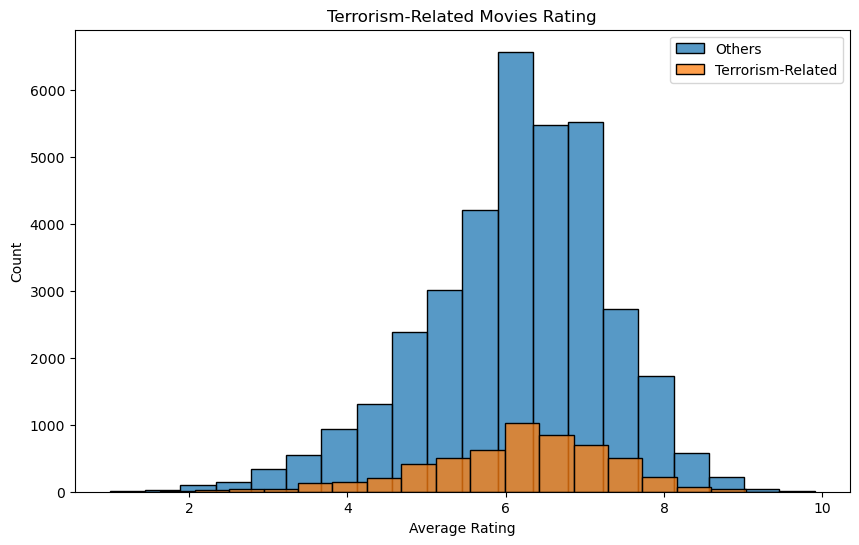

In [ ]:
fig, ax = plt. subplots(figsize= (10,6))
sns.histplot(other_merged['averageRating'], bins=20, label= 'Others')
sns.histplot(terrorism_merged['averageRating'], bins=20, label='Terrorism-Related')
plt.title('Terrorism-Related Movies Rating')
plt.xlabel('Average Rating')
plt.legend()
plt.show()

In [ ]:
from statsmodels.stats import diagnostic

diagnostic.kstest_normal(terrorism_merged['averageRating'].values, dist = 'norm')

(0.07207119835458575, 0.0009999999999998899)

- p_value < 0.05 -> we can reject the null hypothesis that the data comes from a normal distribution!

In [ ]:
diagnostic.kstest_normal(other_merged['averageRating'].values, dist = 'norm')

(0.06341441300821804, 0.0009999999999998899)

- p_value < 0.05 -> we can reject the null hypothesis that the data comes from a normal distribution!

In [ ]:
mean_terror_rating= terrorism_merged['averageRating'].mean()
std_terror_rating= np.std(terrorism_merged['averageRating'], ddof=1)

mean_other_rating= other_merged['averageRating'].mean()
std_other_rating= np.std(other_merged['averageRating'],ddof=1)


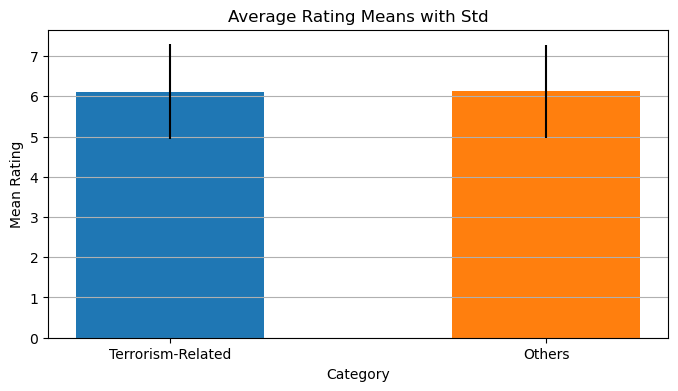

In [ ]:
means= [mean_terror_rating, mean_other_rating]
stds= [std_terror_rating,std_other_rating]
cat= ['Terrorism-Related', 'Others']

fig, ax= plt.subplots(figsize= (8,4))
for i in range(2):   
    plt.bar(cat[i], means[i], yerr= stds[i], width=0.5)
    
plt.ylabel('Mean Rating')
ax.yaxis.grid(True)
plt.xlabel('Category')
plt.title('Average Rating Means with Std')
plt.show()
plt.show()

In [ ]:
print("Rating statistics of 'non-terrorism-movies' ")
other_merged['averageRating'].describe()

Rating statistics of 'non-terrorism-movies' 


count    35912.000000
mean         6.123137
std          1.152253
min          1.000000
25%          5.500000
50%          6.200000
75%          6.900000
max          9.900000
Name: averageRating, dtype: float64

In [ ]:
print("Rating statistics of 'terrorism-movies' ")
terrorism_merged['averageRating'].describe()

Rating statistics of 'terrorism-movies' 


count    5543.000000
mean        6.117644
std         1.175137
min         1.200000
25%         5.400000
50%         6.300000
75%         6.900000
max         9.900000
Name: averageRating, dtype: float64

## 6. Topic Patterns?

### 6.1 Do terrorism movies tend to focus on specific themes? If they do, do different countries or regions portray different themes in their cinematic representation of terrorism?

In [29]:
df_plot = m_plot.rename(columns={0: 'W_movie ID', 1: 'summary'})
df_for_topics = pd.merge(t_movies, df_plot, on='W_movie ID', how='inner')
df_for_topics.drop('Box office revenue', axis =1, inplace=True)
df_for_topics.head(2)

,W_movie ID,Movie name,Release date,Countries,Languages,Genres,summary
0,32986669,Robbery Under Arms,1907-11-02,"{""/m/0chghy"": ""Australia""}","{""/m/06ppq"": ""Silent film""}","{""/m/06ppq"": ""Silent film"", ""/m/07s9rl0"": ""Dra...",Key scenes of the film included the branding o...
1,7870349,Dr. Jekyll and Mr. Hyde,1908-03-07,"{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",Dr. Jekyll and Mr. Hyde began with the raising...


In this section we remove all rows containing null values for Countries as it will be an essential tool in our computation.


In [31]:
contains_empty_json = df_for_topics['Countries'].apply(is_empty_json)
filtered_df_for_topics = df_for_topics[~contains_empty_json]

### 6.2  Number of movies per country

Now we would like to see how many different countries we can find in our data set in order to check if we can classify the movies per country.

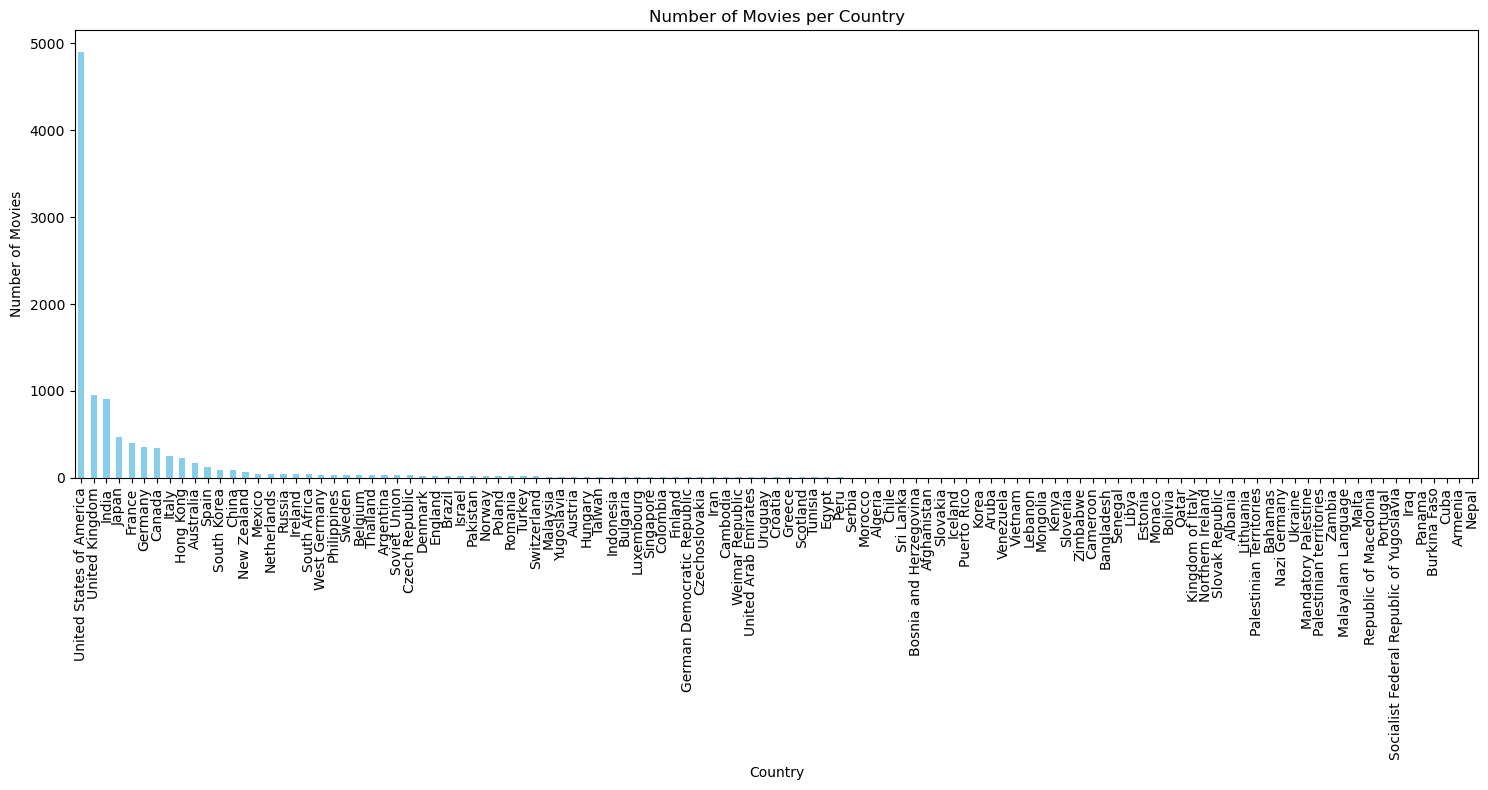

In [32]:
unique_countries = []
for countries_str in filtered_df_for_topics['Countries']:
    unique_countries.extend(extract_countries(countries_str))
# Count the occurrences of each country
country_counts = pd.Series(unique_countries).value_counts()
# Plotting
plt.figure(figsize=(15, 8))
country_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Movies per Country')
plt.xlabel('Country')
plt.ylabel('Number of Movies')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

We notice that classifying movies per country is not efficient as there is an imbalanced number of movies per country thus we decided to do a classification per region.

### 6.3 Number of movies per region

**Data set for regions:** https://www.itu.int/en/ITU-D/Statistics/Pages/definitions/regions.aspx 


In [33]:
df_regions = pd.read_excel('data/Countries_Region.xlsx')
dfs = []
new_df_regions = pd.DataFrame(['Country, Region'])
for i in df_regions.columns:
    region_name = i
    # Create a DataFrame for each region with 'Country' and 'Region' columns
    temp_df = pd.DataFrame({'Country': df_regions[i].dropna(), 'Region': region_name})
    
    # Append each region DataFrame to the list
    dfs.append(temp_df)
new_df_regions = pd.concat(dfs, ignore_index=True)

In [34]:
# Extract unique values from the renamed columns
countries_list = []
for column in df_regions.columns:
        countries_list.extend(df_regions[column].unique().tolist())
unique_countries = set(unique_countries)
countries_not_in_list = [country for country in unique_countries if country not in countries_list]

# Display the list of countries not contained in the 'unique_countries_list'
print("Countries not contained in the unique list:", len(countries_not_in_list))

Countries not contained in the unique list: 31


We noticed that in this data set some countries are not mapped to regions thus we will map them manually:

In [35]:
country_to_region = {
    'United States of America': 'America',
    'West Germany': '​Europ Region',
    'Scotland': '​Europ Region',
    'Taiwan': 'Asia and Pacific',
    'South Korea': 'Asia and Pacific',
    'Monaco': '​Europ Region',
    'Weimar Republic': '​Europ Region',
    'Nepal': 'Asia and Pacific',
    'Iran': '​Arab States',
    'Soviet Union': 'Cis',
    'Nazi Germany': '​Europ Region',
    'Aruba': 'America',
    'Kingdom of Italy': '​Europ Region',
    'Palestinian Territories': '​Arab States',
    'Russia': 'Cis',
    'England': '​Europ Region',
    'Yugoslavia': '​Europ Region',
    'Puerto Rico': 'America',
    'Palestinian territories': '​Arab States',
    'Vietnam': 'Asia and Pacific',
    'Hong Kong': 'Asia and Pacific',
    'Socialist Federal Republic of Yugoslavia': '​Europ Region',
    'Bolivia': 'America',
    'Korea': 'Asia and Pacific',
    'Slovak Republic': '​Europ Region',
    'Malayalam Language': 'Asia and Pacific',
    'Republic of Macedonia': '​Europ Region',
    'Czechoslovakia': '​Europ Region',
    'Mandatory Palestine': '​Arab States',
    'German Democratic Republic': '​Europ Region',
    'Northern Ireland': '​Europ Region'
}

In [36]:
country_to_region_df = pd.DataFrame(country_to_region.items(), columns=['Country', 'Region'])
final_df_regions = pd.concat([country_to_region_df, new_df_regions], ignore_index=True)
filtered_df_for_topics['Country_extract'] = filtered_df_for_topics['Countries'].apply(extract_countries_from_dictionary)

def map_region(country_list):
    return final_df_regions[final_df_regions['Country'].isin(country_list)]['Region'].tolist()

# Apply the function to create a new column 'Region' in filtered_df_for_topics
filtered_df_for_topics['Region'] = filtered_df_for_topics['Country_extract'].apply(map_region)

  4%|▎         | 31.5M/885M [04:33<2:03:41, 115kB/s]


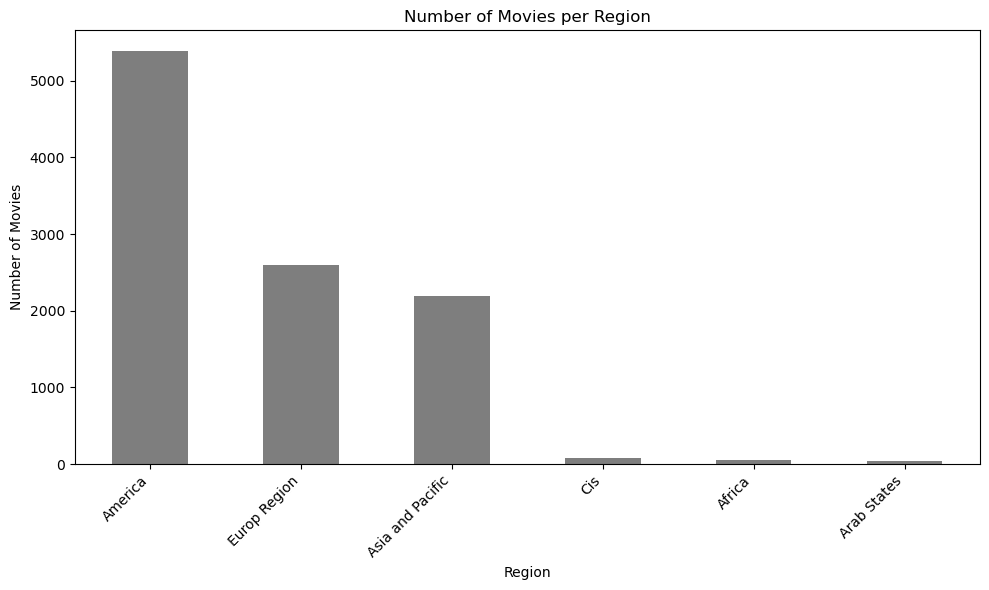

In [37]:
flattened_regions = filtered_df_for_topics['Region'].explode()
movies_per_region = flattened_regions.value_counts()
# Plot the number of movies per region
plt.figure(figsize=(10, 6))
movies_per_region.plot(kind='bar', color='#7e7e7e')
plt.title('Number of Movies per Region')
plt.xlabel('Region')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

Cis represents Commonwealth of Independent States.

In [38]:
print("Count of movies per region:")
print(movies_per_region)

Count of movies per region:
Region
America             5389
​Europ Region       2597
Asia and Pacific    2190
Cis                   73
Africa                50
​Arab States          36
Name: count, dtype: int64


In [39]:
# Sort the DataFrame by 'Release date'

exploded_df = filtered_df_for_topics.explode('Region').sort_values('Release date')
exploded_df['Release date']=  exploded_df['Release date'].str[:4]
exploded_df.dropna(subset=['Release date'], inplace=True)
exploded_df['Release date'] = pd.to_datetime(exploded_df['Release date'])

# Create a DataFrame suitable for Plotly
plotly_df = exploded_df.groupby(['Region', 'Release date']).size().reset_index(name='Number of Movies')
# Interactive Plot
fig = px.line(plotly_df, x='Release date', y='Number of Movies', color='Region',
              title='Interactive Plot of Movies per Year for Each Region',
              labels={'Release date': 'Release Year', 'Number of Movies': 'Count'})

fig.update_xaxes(rangeslider_visible=True)
fig.show()

We can notive here that there are not enough movies to make an analysis for CIS region, Arab States and Africa thus we will do our topic modelling analysis on the other three regions.

### 6.4 Number of movies per release date for each region

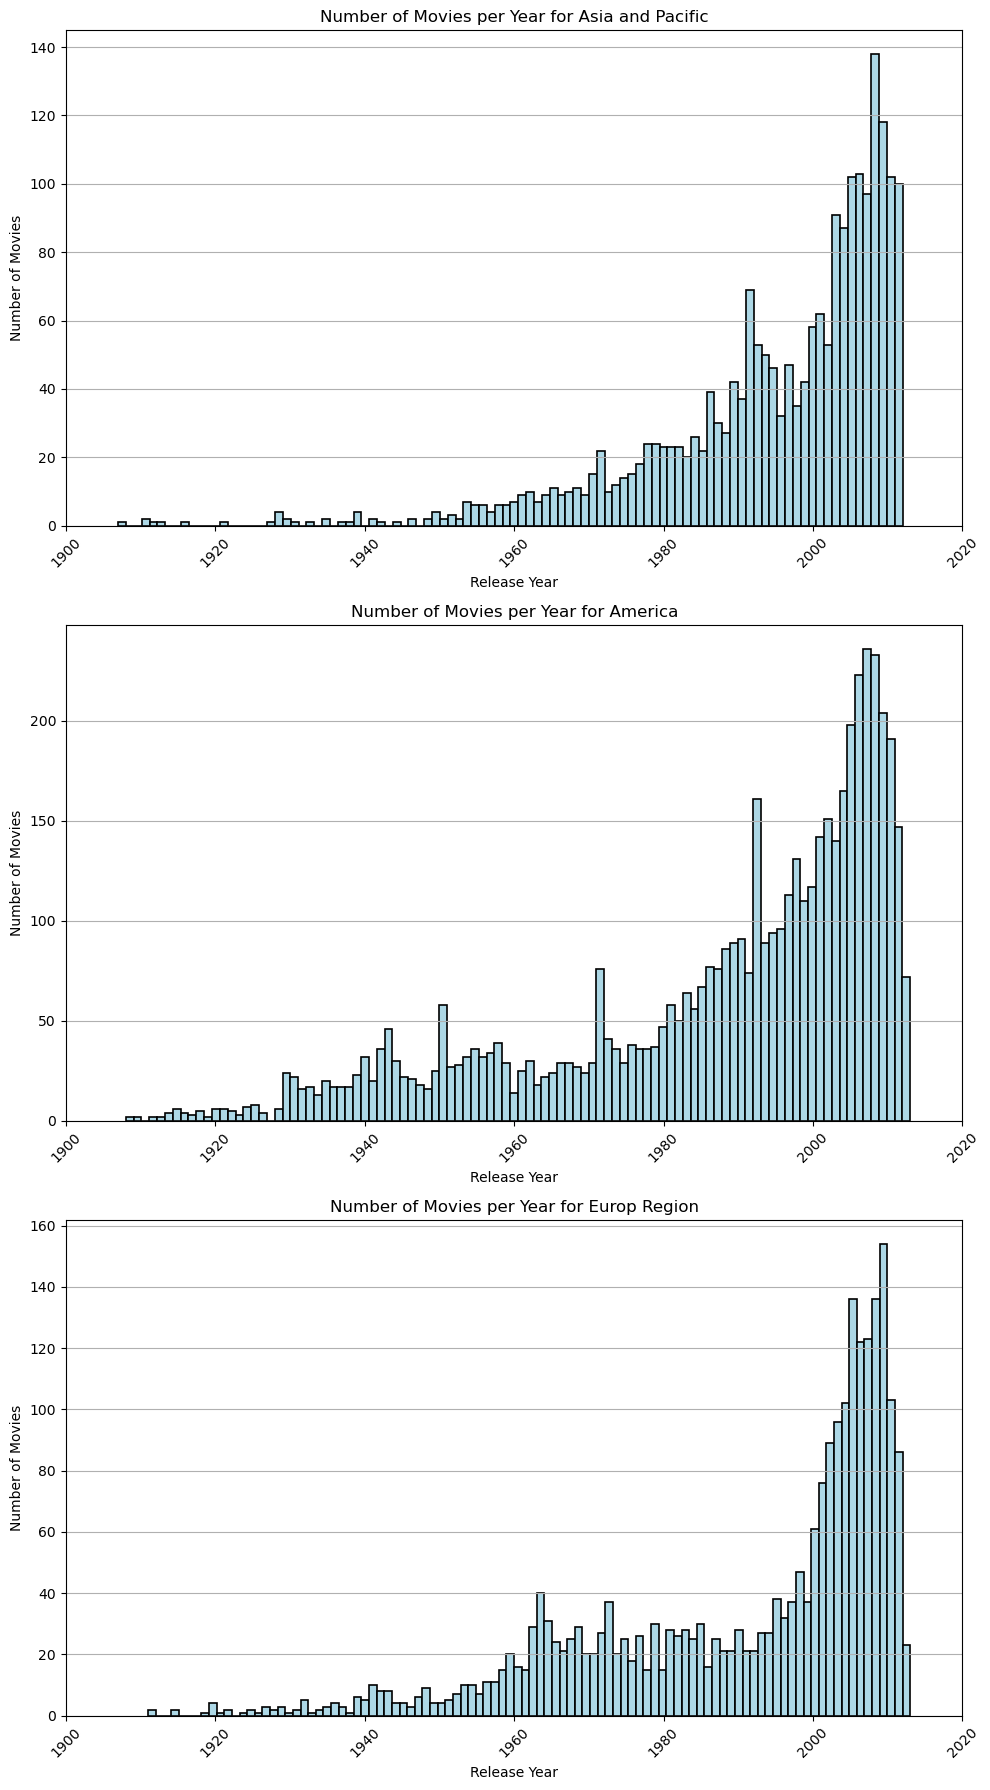

In [40]:
movies_per_year_per_region = (exploded_df.groupby(['Region', 'Release date'])
                                        .size()
                                        .unstack(fill_value=0))
unique_regions = exploded_df['Region'].unique()[:3]
fig, axes = plt.subplots(nrows=len(unique_regions), figsize=(10, 6 * len(unique_regions)))

exploded_df['Release date'] = exploded_df['Release date'].dt.year

for i, region in enumerate(unique_regions):
    # Select data for the current region
    region_data = exploded_df[exploded_df['Region'] == region]['Release date'].sort_values()
    axes[i].hist(region_data, bins=100, linewidth=1.2, edgecolor='black', color='lightblue')
    axes[i].set_xlabel('Release Year')
    axes[i].set_ylabel('Number of Movies')
    axes[i].set_title(f'Number of Movies per Year for {region}')
    axes[i].set_xticks(axes[i].get_xticks())
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(axis='y')

plt.tight_layout()
plt.show()
    

### 6.5 Topic Modelling using LDA

LDA is a generative probabilistic model that assumes each topic is a mixture over an underlying set of words, and each document is a mixture of over a set of topic probabilities.

We first start by importing the necessary libraries to run LDA then cleaning and tokeninzing our movie data set.

#### 6.5.1 Text Cleaning & Tokenization

In [43]:
#Lowercase
df_data = TextNet(
    data=filtered_df_for_topics,
    column="summary"
).lowercase()

#Remove punctuation
df_data = TextNet(
    data=df_data,
    column="summary"
).remove_punctuation()

df_data = TextNet(
    data=df_data,
    column="summary"
).remove_url()

df_data = TextNet(
    data=df_data,
    column="summary"
).remove_html()

df_data = TextNet(
    data=df_data,
    column="summary"
).remove_email()

df_data = TextNet(
    data=df_data,
    column="summary"
).remove_digit()

df_data = TextNet(
    data=df_data,
    column="summary"
).remove_mention()

df_data = TextNet(
    data=df_data,
    column="summary"
).remove_single_character()

df_data = TextNet(
    data=df_data,
    column="summary"
).additional_cleaning(
    add_regexs=None
)

In [44]:
#Remove stopwords
def remove_stopword(text : str) -> str:
    list_stopwords = stopwords.words("english")
    return " ".join(
        [word for word in word_tokenize(text) if word not in list_stopwords]
    )

df_data["summary"] = df_data["summary"].apply(remove_stopword)

In [45]:
#Lemmatize
def lemmatize(text : str) -> str:
    lemmatizer = WordNetLemmatizer()
    return " ".join(
        [lemmatizer.lemmatize(word) for word in word_tokenize(text)]
    )

df_data["summary"] = df_data["summary"].apply(lemmatize)

In [46]:
#Remove Spaces
df_data = TextNet(
    data=df_data,
    column="summary"
).remove_space()

df_data = TextNet(
    data=df_data,
    column="summary"
).remove_whitespace()

In [50]:
#Tokenization 
df_data["text_tokenized"] = df_data["summary"].apply(lambda x: word_tokenize(x))
words_to_remove = ['one', 'find', 'get', 'go', 'two', 'tell', 'film', 'see', 'vampire']
df_data["text_tokenized"] = df_data["text_tokenized"].apply(
    lambda tokens: [token for token in tokens if token not in words_to_remove]
)

#### 6.5.2 Topic Modeling with LDA

Each time we run an LDA we need to create a dictionary out of the dataframe used, we will run it on different parts of the dataframe to see if there will be a link between topics and countries and any common pattern.

In [62]:
def run_lda(df, num_topics=4):
    dictionary = corpora.Dictionary(df["text_tokenized"])
    doc_term_matrix = [dictionary.doc2bow(paper) for paper in df["text_tokenized"]]
    lda_model = LdaMulticore(
        corpus=doc_term_matrix,
        id2word=dictionary,
        num_topics=num_topics,
        random_state=42,
        chunksize=200,
        passes=100,
        per_word_topics=True
    )
    
    return lda_model

def print_topics(lda_model):
    list_colors = ["#17C37B", "#F92969", "#FACA0C", "#0D1117"]

    wc = WordCloud(
        background_color="white",
        max_words=10,
        max_font_size=300,
        colormap="tab10",
        color_func=lambda *args, **kwargs: list_colors[i],
        prefer_horizontal=1.0
    )

    topics = lda_model.show_topics(formatted=False)

    fig, axes = plt.subplots(2, 2, figsize=(8, 5), sharey=True, dpi=80)

    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        wc.generate_from_frequencies(topic_words)
        plt.gca().imshow(wc)
        plt.gca().set_title("Topic "+str(i), fontdict=dict(size=16))
        plt.gca().axis("off")

    plt.axis("off")
    plt.subplots_adjust(wspace=0.1, hspace=0)
    plt.margins(x=0, y=0)
    plt.show()

We saw earlier that the most represented countries in our data set were in America, Asia and Pacific or Europ. We noticed also that there are more movies for  "United States of America", "United Kingdom", "India", "Japan", "France", "Germany", "Canada", "Italy", "Hong Kong" and "Australia". We will thus look first for topics in general and then we will do an analysis per country.

In [52]:
lda_model_general = run_lda(df_data, num_topics=4)
lda_model_general.print_topics()

[(0,
  '0.004*"take" + 0.003*"back" + 0.003*"police" + 0.003*"car" + 0.003*"man" + 0.003*"new" + 0.003*"time" + 0.003*"life" + 0.002*"make" + 0.002*"friend"'),
 (1,
  '0.005*"house" + 0.005*"back" + 0.004*"take" + 0.004*"kill" + 0.003*"home" + 0.003*"try" + 0.003*"man" + 0.003*"later" + 0.003*"father" + 0.003*"night"'),
 (2,
  '0.005*"father" + 0.004*"love" + 0.004*"take" + 0.004*"police" + 0.004*"kill" + 0.004*"family" + 0.004*"life" + 0.004*"son" + 0.003*"friend" + 0.003*"brother"'),
 (3,
  '0.005*"attack" + 0.004*"ship" + 0.003*"back" + 0.003*"escape" + 0.003*"take" + 0.003*"kill" + 0.003*"men" + 0.003*"soldier" + 0.003*"order" + 0.003*"group"')]

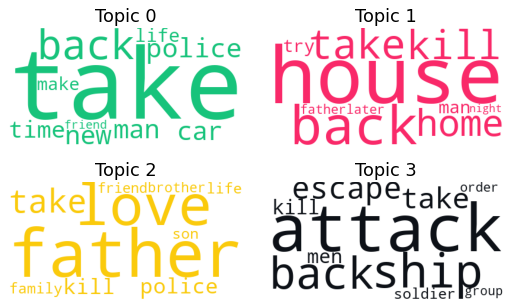

In [63]:
print_topics(lda_model_general)

Now we will display the topic modelling for each country in the list above and we will analyse the results.

In [81]:
countries_of_interest = [
        "United States of America", "United Kingdom", "India", "Japan",
        "France", "Germany", "Canada", "Italy", "Hong Kong", "Australia"]
exploded_df = filtered_df_for_topics.explode('Country_extract').sort_values('Release date')
df_countries = exploded_df[exploded_df['Country_extract'].isin(countries_of_interest)]
df_topics_LDA = pd.read_csv('data/topic_data/df_topics_LDA.csv')
for country in countries_of_interest:
    if df_topics_LDA.empty:
        print(country)
        df_country = df_countries[df_countries['Country_extract'] == country]
        run_lda(df_country, num_topics=4).print_topics()
        print_topics(run_lda(df_country, num_topics=4))
    else:
        words = df_topics_LDA[df_topics_LDA['Country'] == country]
        words = words.groupby('Topic')['Word'].apply(list).reset_index(name='Words')
        print(country, 'topics :')
        print(words)


United States of America topics :
   Topic                                              Words
0      0  [king, back, kill, return, take, harry, attack...
1      1  [house, back, car, take, home, father, man, fr...
2      2  [dr, back, escape, earth, ship, attack, kill, ...
3      3  [kill, agent, war, order, escape, take, attack...
United Kingdom topics :
   Topic                                              Words
0      0  [harry, kill, father, king, return, take, men,...
1      1  [kill, bond, escape, attack, alice, new, dr, k...
2      2  [back, house, car, man, father, home, take, la...
3      3  [take, family, child, mr, later, friend, war, ...
India topics :
   Topic                                              Words
0      0  [terrorist, khan, take, police, life, kill, da...
1      1  [family, love, father, come, friend, life, hou...
2      2  [father, raju, ravi, love, take, come, kill, r...
3      3  [police, kill, father, love, raj, ajay, take, ...
Japan topics :
   Topic    

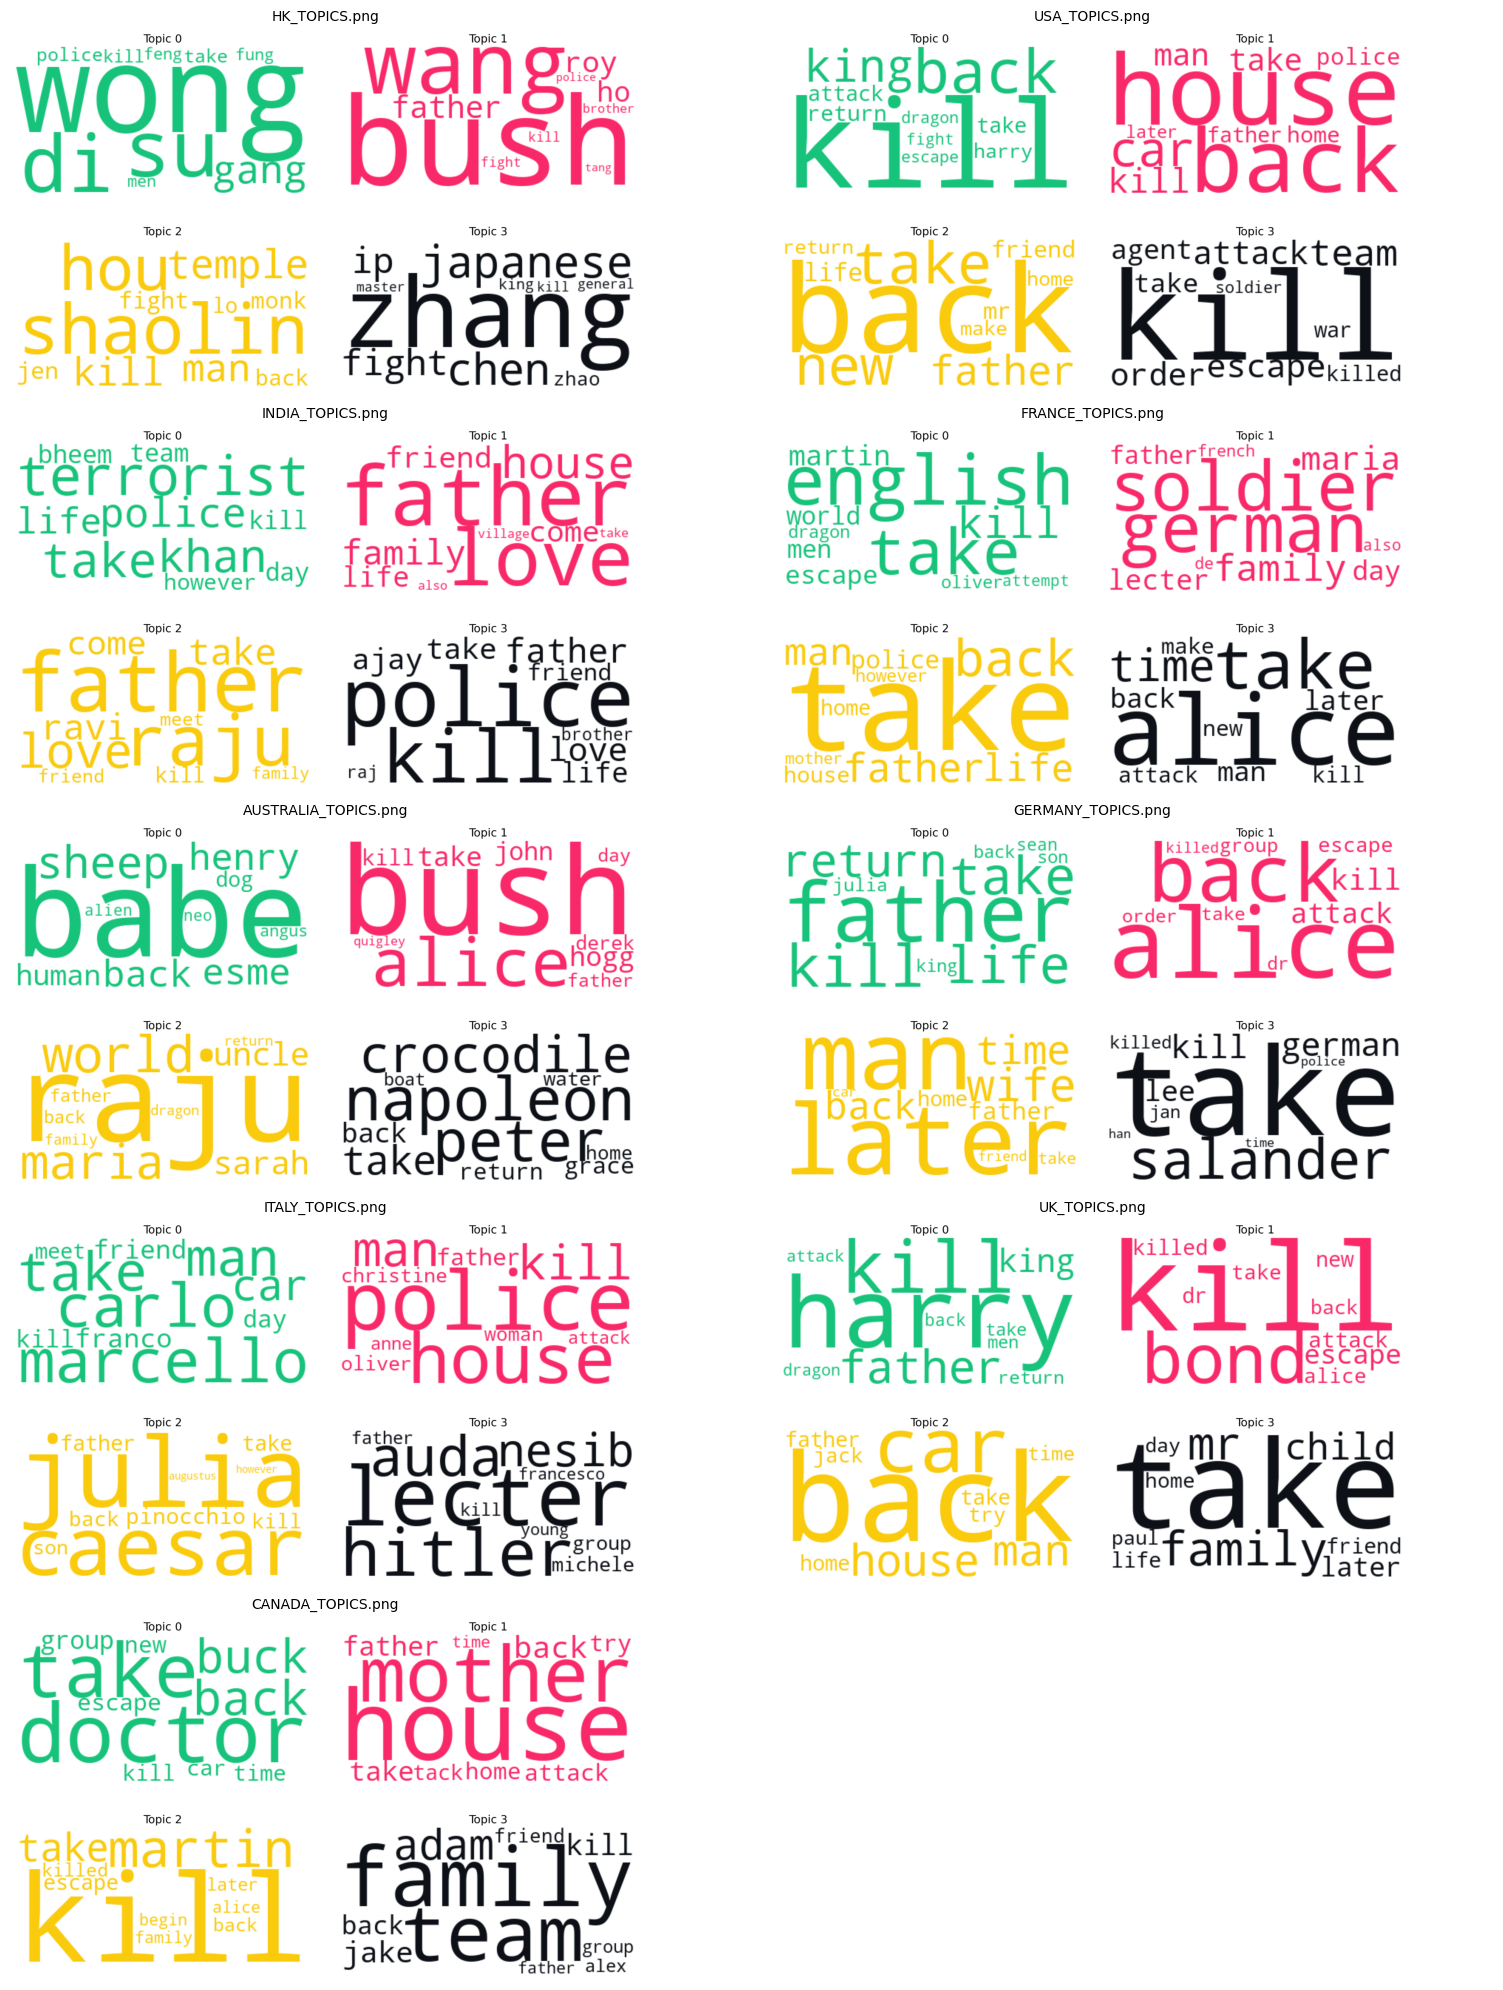

In [87]:
import matplotlib.image as mpimg

folder_path = 'data/topic_data/'
# List all files in the folder and filter for PNG files
png_files = [f for f in os.listdir(folder_path) if f.endswith('.png')]
# Determine the number of rows needed for a 2x2 layout
num_images = len(png_files)
num_rows = num_images // 2 + (num_images % 2 > 0)
# Create a figure with subplots
fig, axes = plt.subplots(num_rows, 2, figsize=(16, num_rows * 4))
# Flatten the axes array for easy iteration
axes_flat = axes.flatten()
# Loop through the files and add them to the subplots
for i, file in enumerate(png_files):
    img_path = os.path.join(folder_path, file)
    img = mpimg.imread(img_path)
    axes_flat[i].imshow(img)
    axes_flat[i].axis('off')
    axes_flat[i].set_title(file, fontsize=10)    # Hide axis labels
# If the number of images is odd, hide the last axis
if num_images % 2 != 0:
    axes_flat[-1].axis('off')
plt.tight_layout()
plt.show()

Based on the analysis of the top words from each topic within the provided countries we infered that there are **noticeable topic pattern** across movies from different countries, these pattern appear to be recurrent, such as "kill," "attack," "take," "back," and "escape." These terms are indicative of action and conflict, which are common elements in terrorism movies. This suggests a universal cinematic language when it comes to portraying terrorism, focusing on the suspense and drama associated with such events. Moreover there are also **specific themes** especially on family and personal relationships with words like "father," "mother," and "son" appearing across different topics. This indicates that terrorism movies often explore the impact of terrorism on personal lives and relationships. We find this pattern in US and India Movies 
in which frequent mentions of "father," "mother," and "family" suggest that American terrorism movies often delve into the impact of terrorism on family dynamics words and  like "father" and "love" indicate a tendency to intertwine personal relationships and emotional elements with the broader theme of terrorism in Indian Movies.

In comparison, both American and Indian terrorism movies share a common focus on the human element, particularly on the impact of terrorism on families and personal relationships. This commonality suggests that, despite the cultural differences, the personal dimensions of terrorism have a universal resonance in cinema. However, the differences are also telling: American films tend to depict a more tactical and military response to terrorism, which aligns with the nation's prominent international security role. In contrast, Indian films place greater emphasis on the societal and emotional narratives of terrorism, reflecting the country’s cinematic history of integrating deep emotional narratives with complex social issues.

While there is a global trend in these films to focus on direct conflict, action, and familial impact, reflecting the personal and social ramifications of terrorism, countries also embed their unique historical, cultural, and political narratives into these portrayals.For instance, French terrorism films may weave in elements related to historical conflicts such as World War II, using terms like "soldier" and "german." Japanese cinema, on the other hand, might present themes of disaster and invasion through a cultural lens, with references to iconic figures like "godzilla." Italian films could draw from Italy's rich historical and cultural tapestry, as indicated by words like "caesar" and "pinocchio.

